## GPT4 Response Parsing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
def response_parser(response):
    """
    Split the response into Steps, extract the symptoms, category and score.
    Works for simple PHQ9 prompt template
    """
    try:
        response_json = eval(response)
    except:
        response = response.replace('null', "'null'")
        response_json = eval(response)
        
    if not isinstance(response_json, dict):
        return {}
    
    ITEMS = ['Feeling depressed', 'Lack of interest', 'Trouble falling asleep or sleeping too much', 'Fatigue', 'Poor appetite or overeating', 'Feeling bad about oneself', 'Difficulty concentrating', 'Moving or speaking slowly or too quickly', 'Thoughts of death or suicide']
    ITEMS_UNDERSCORED = {i:i.replace(' ', '_') for i in ITEMS}
    
    phq9_items = {}
    
    for item, item_list in response_json['STEP 1'].items():
        phq9_items[item] = {'scores': [], 'reasons': [], 'isInferred': 0}
        phq9_items[item]['reasons'].append(item_list[0])
        if item_list[1] in [-1, 'null', 'Not Mentioned', 'N/A', 'Not Evaluated', 'Not evaluated', 'Not mentioned']:
            phq9_items[item]['scores'].append(0)
        # elif item_list[1] == 0 and ("no explicit" in item_list[0].lower() or "not mentioned" in item_list[0].lower()):
        #     continue
        else:
            phq9_items[item]['scores'].append(item_list[1])


    for item, item_list in response_json['STEP 2'].items():
        if item not in phq9_items:
            phq9_items[item] = {'scores': [], 'reasons': [], 'isInferred': 1}
        phq9_items[item]['reasons'].append(item_list[0])
        phq9_items[item]['scores'].append(item_list[1])
        phq9_items[item]['isInferred'] = 1

    if len(response_json['STEP 3']['Final']) == 3:
        score = response_json['STEP 3']['Final'][1]
        category = response_json['STEP 3']['Final'][2]
    else:
        score = response_json['STEP 3']['Final'][0]
        category = response_json['STEP 3']['Final'][1]
    
    if isinstance(score, str):
        score = response_json['STEP 3']['Final'][0].replace('Total Score: ', ' ').strip()    
    score = float(score)        
    
    if category.startswith('Category: '):
        category = category.replace('Category: ', '').strip()
        
    underscore_dict = {}    
    for item, item_underscored in ITEMS_UNDERSCORED.items():
        if item in phq9_items:
            underscore_dict['score_'+item_underscored] = sum(phq9_items[item]['scores'])
            underscore_dict['reason_'+item_underscored] = ' '.join(phq9_items[item]['reasons'])
            underscore_dict['isInferred_'+item_underscored] = phq9_items[item]['isInferred']
        else:
            if item == "Trouble falling asleep or sleeping too much" and "Trouble falling asleep" in phq9_items:
                    underscore_dict['score_'+item_underscored] = sum(phq9_items["Trouble falling asleep"]['scores'])
                    underscore_dict['reason_'+item_underscored] = ' '.join(phq9_items["Trouble falling asleep"]['reasons'])
                    underscore_dict['isInferred_'+item_underscored] = phq9_items["Trouble falling asleep"]['isInferred']
            elif item == "Poor appetite or overeating" and "Poor appetite" in phq9_items:
                    underscore_dict['score_'+item_underscored] = sum(phq9_items["Poor appetite"]['scores'])
                    underscore_dict['reason_'+item_underscored] = ' '.join(phq9_items["Poor appetite"]['reasons'])
                    underscore_dict['isInferred_'+item_underscored] = phq9_items["Poor appetite"]['isInferred']
            elif item == "Moving or speaking slowly or too quickly" and "Moving or speaking slowly" in phq9_items:
                    underscore_dict['score_'+item_underscored] = sum(phq9_items["Moving or speaking slowly"]['scores'])
                    underscore_dict['reason_'+item_underscored] = ' '.join(phq9_items["Moving or speaking slowly"]['reasons'])
                    underscore_dict['isInferred_'+item_underscored] = phq9_items["Moving or speaking slowly"]['isInferred']
            else:
                print ('Missing {}'.format(item))
                underscore_dict['score_'+item_underscored] = 0
                underscore_dict['reason_'+item_underscored] = ''
                underscore_dict['isInferred_'+item_underscored] = -1
    
    underscore_dict['score'] = score
    underscore_dict['category'] = category
    underscore_dict['symptoms'] = phq9_items
    
    return underscore_dict

In [3]:
RESPONSE_FILE_PATH = "/chronos_data/avirinchipur/reasoning_for_psych/expts/responses/expt_gpt-4.dep_list_phq9items_score_classify_editted.csv"

In [4]:
response_df = pd.read_csv(RESPONSE_FILE_PATH)
response_df.head()

,user_id,input_text,target_value,response_text,user_text
0,1,"[{'role': 'system', 'content': 'You are a help...",0,"{\n ""STEP 1"": {\n ""Lack of interest"": [""Th...","Over the past two weeks, I have not been depre..."
1,2,"[{'role': 'system', 'content': 'You are a help...",17,"{\n ""STEP 1"": {\n ""Feeling depressed"": [""T...",I don't think I have felt depressed. I'm not f...
2,3,"[{'role': 'system', 'content': 'You are a help...",21,"{\n ""STEP 1"": {\n ""Feeling depressed"": [""T...",I have been depressed because I am worried abo...
3,4,"[{'role': 'system', 'content': 'You are a help...",13,"{\n ""STEP 1"": {\n ""Feeling depressed"": [""T...",Over the past 2 weeks i have been feeling depr...
4,5,"[{'role': 'system', 'content': 'You are a help...",9,"{\n ""STEP 1"": {\n ""Feeling depressed"": [""T...",yes very much just seem everything is getting ...


In [5]:
# Removing bad response
str_to_match = 'Please answer the question by typing at least a paragraph below that indicates whether you have been worried or not. Try to weigh the strength and the number of aspects that describe if you have been worried or not so that they reflect your overall personal state of worry. For example, if you have been worried then write more about aspects describing this, and if you have not been worried then write more about aspects describing that. \n\nWrite about those aspects that are most important and meaningful to you.'
response_df = response_df[response_df['user_text'] != str_to_match]

In [6]:
user_text, example_response_text = response_df.sample(frac=1.0)[['user_text', 'response_text']].values[0]
print (user_text)
print (example_response_text)

Thought I was OK til a few days ago when I realised I was really missing not going out and visiting friends and places
{
  "STEP 1": {
    "Feeling depressed": ["The author expresses feeling down after realizing they miss going out and visiting friends and places", 2],
    "Lack of interest": ["The author implies a lack of interest in their current activities by stating they miss going out and visiting friends and places", 1]
  },
  "STEP 2": {
    "Trouble falling asleep or sleeping too much": ["No explicit mention in the text, but depression can often lead to sleep disturbances", 1],
    "Fatigue": ["No explicit mention in the text, but depression can often lead to feelings of fatigue", 1],
    "Poor appetite or overeating": ["No explicit mention in the text, but depression can often lead to changes in appetite", 0],
    "Feeling bad about oneself": ["No explicit mention in the text, but feeling depressed can often lead to negative self-perception", 1],
    "Difficulty concentrating"

In [7]:
pprint (response_parser(example_response_text))

{'category': 'Mild',
 'isInferred_Difficulty_concentrating': 1,
 'isInferred_Fatigue': 1,
 'isInferred_Feeling_bad_about_oneself': 1,
 'isInferred_Feeling_depressed': 0,
 'isInferred_Lack_of_interest': 0,
 'isInferred_Moving_or_speaking_slowly_or_too_quickly': 1,
 'isInferred_Poor_appetite_or_overeating': 1,
 'isInferred_Thoughts_of_death_or_suicide': 1,
 'isInferred_Trouble_falling_asleep_or_sleeping_too_much': 1,
 'reason_Difficulty_concentrating': 'No explicit mention in the text, but '
                                    'depression can often lead to difficulty '
                                    'concentrating',
 'reason_Fatigue': 'No explicit mention in the text, but depression can often '
                   'lead to feelings of fatigue',
 'reason_Feeling_bad_about_oneself': 'No explicit mention in the text, but '
                                     'feeling depressed can often lead to '
                                     'negative self-perception',
 'reason_Feeling_depresse

In [8]:
response_df['parsed_response'] = response_df['response_text'].apply(response_parser)

Missing Fatigue
Missing Trouble falling asleep or sleeping too much


In [9]:
parsed_response_df = pd.concat((response_df[['user_id', 'target_value']], pd.DataFrame(response_df['parsed_response'].tolist(), index=response_df.index)), axis=1)
parsed_response_df

,user_id,target_value,score_Feeling_depressed,reason_Feeling_depressed,isInferred_Feeling_depressed,score_Lack_of_interest,reason_Lack_of_interest,isInferred_Lack_of_interest,score_Trouble_falling_asleep_or_sleeping_too_much,reason_Trouble_falling_asleep_or_sleeping_too_much,...,isInferred_Difficulty_concentrating,score_Moving_or_speaking_slowly_or_too_quickly,reason_Moving_or_speaking_slowly_or_too_quickly,isInferred_Moving_or_speaking_slowly_or_too_quickly,score_Thoughts_of_death_or_suicide,reason_Thoughts_of_death_or_suicide,isInferred_Thoughts_of_death_or_suicide,score,category,symptoms
0,1,0,0,"The author states 'I have not been depressed',...",0,0,The author states 'I have been interested in t...,0,0,The author states 'my sleep has been pretty go...,...,1,0,No explicit mention of moving or speaking slow...,1,0,No explicit mention of thoughts of death or su...,1,0.0,None,"{'Lack of interest': {'scores': [0], 'reasons'..."
1,2,17,0,The author states 'I don't think I have felt d...,0,2,The author mentions 'I do find it hard to get ...,0,1,"No explicit mention in the text, but lack of i...",...,1,1,"No explicit mention in the text, but lack of i...",1,0,"No explicit mention in the text, and no clear ...",1,8.0,Mild,"{'Feeling depressed': {'scores': [0], 'reasons..."
2,3,21,3,The author explicitly mentions feeling depress...,0,1,The author does not mention any lack of intere...,1,1,"The author does not mention any sleep issues, ...",...,0,0,The author does not mention any changes in mov...,1,0,The author does not mention any suicidal thoug...,1,9.0,Moderate,"{'Feeling depressed': {'scores': [3], 'reasons..."
3,4,13,3,The author explicitly mentions feeling depress...,0,2,"The author mentions not being able to go out, ...",0,2,"Not explicitly mentioned, but often correlated...",...,1,1,"Not explicitly mentioned, but often correlated...",1,1,"Not explicitly mentioned, but often correlated...",1,15.0,Moderately Severe,"{'Feeling depressed': {'scores': [3], 'reasons..."
4,5,9,2,The author mentions feeling overwhelmed by the...,0,1,Based on the author's feeling of being overwhe...,1,2,The author mentions their routine as 'just wor...,...,1,0,No clear correlation can be made with the iden...,1,0,No clear correlation can be made with the iden...,1,9.0,Moderate,"{'Feeling depressed': {'scores': [2], 'reasons..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,972,11,1,The overall tone of the text suggests the auth...,1,2,The author mentions 'not wanted to get dressed...,0,1,The author does not mention any issues with sl...,...,1,1,The author does not mention any issues with mo...,1,1,The author does not mention any thoughts of de...,1,10.0,Moderate,"{'Lack of interest': {'scores': [2], 'reasons'..."
952,973,20,2,"The author mentions feeling down, which indica...",0,2,The author expresses a lack of motivation or i...,0,1,"Based on the author's worry and feeling down, ...",...,0,0,There is no mention of the author's physical m...,1,0,There is no mention of suicidal thoughts or th...,1,9.0,Moderate,"{'Feeling depressed': {'scores': [2], 'reasons..."
953,974,20,0,The author explicitly states 'I haven’t felt d...,0,1,Not explicitly mentioned in the text. Estimate...,1,1,Not explicitly mentioned in the text. Estimate...,...,1,1,Not explicitly mentioned in the text. Estimate...,1,0,Not explicitly mentioned in the text. Estimate...,1,7.0,Mild,"{'Feeling depressed': {'scores': [0], 'reasons..."
954,975,22,3,"The author mentions suffering from depression,...",0,3,The author states they have no motivation.,0,3,The author mentions oversleeping.,...,0,2,"Not explicitly mentioned, but given the severi...",1,2,"Not explicitly mentioned, but given the severi...",1,25.0,Severe,"{'Feeling depressed': {'scores': [3], 'reasons..."


In [10]:
ITEMS = ['Feeling depressed', 'Lack of interest', 'Trouble falling asleep or sleeping too much', 'Fatigue', 'Poor appetite or overeating', 'Feeling bad about oneself', 'Difficulty concentrating', 'Moving or speaking slowly or too quickly', 'Thoughts of death or suicide']
ITEMS_UNDERSCORED = {i:i.replace(' ', '_') for i in ITEMS}
score_columns = ['score_{}'.format(i) for i in ITEMS_UNDERSCORED.values()]    

parsed_response_df[parsed_response_df['score'] != parsed_response_df[score_columns].sum(1)][score_columns + ['score']]

,score_Feeling_depressed,score_Lack_of_interest,score_Trouble_falling_asleep_or_sleeping_too_much,score_Fatigue,score_Poor_appetite_or_overeating,score_Feeling_bad_about_oneself,score_Difficulty_concentrating,score_Moving_or_speaking_slowly_or_too_quickly,score_Thoughts_of_death_or_suicide,score
44,2,1,1,1,1,2,1,1,1,10.0
81,3,1,1,1,1,1,2,1,1,10.0
90,3,2,1,1,1,2,1,1,1,12.0
157,3,1,1,1,1,1,1,1,1,10.0
161,1,1,1,1,1,1,1,1,0,7.0
...,...,...,...,...,...,...,...,...,...,...
918,1,3,1,1,1,1,1,1,1,10.0
920,3,1,1,1,1,1,1,1,1,9.0
948,3,2,1,3,1,2,3,1,1,18.0
950,2,1,1,1,1,1,1,1,1,9.0


In [11]:
diff = parsed_response_df['score'] - parsed_response_df[score_columns].sum(1)
diff.value_counts()

 0.0    861
-1.0     71
-2.0     12
 1.0      6
 2.0      5
dtype: int64

In [12]:
null_userids = parsed_response_df[parsed_response_df.score.isnull()]
null_userids

,user_id,target_value,score_Feeling_depressed,reason_Feeling_depressed,isInferred_Feeling_depressed,score_Lack_of_interest,reason_Lack_of_interest,isInferred_Lack_of_interest,score_Trouble_falling_asleep_or_sleeping_too_much,reason_Trouble_falling_asleep_or_sleeping_too_much,...,isInferred_Difficulty_concentrating,score_Moving_or_speaking_slowly_or_too_quickly,reason_Moving_or_speaking_slowly_or_too_quickly,isInferred_Moving_or_speaking_slowly_or_too_quickly,score_Thoughts_of_death_or_suicide,reason_Thoughts_of_death_or_suicide,isInferred_Thoughts_of_death_or_suicide,score,category,symptoms


In [13]:
print ("Number of instances with missing estimates for items")
for item in ITEMS_UNDERSCORED.values():
    print ("{}: {}".format(item, parsed_response_df[parsed_response_df['isInferred_'+item]==-1].shape[0]))

Number of instances with missing estimates for items
Feeling_depressed: 0
Lack_of_interest: 0
Trouble_falling_asleep_or_sleeping_too_much: 1
Fatigue: 1
Poor_appetite_or_overeating: 0
Feeling_bad_about_oneself: 0
Difficulty_concentrating: 0
Moving_or_speaking_slowly_or_too_quickly: 0
Thoughts_of_death_or_suicide: 0


In [14]:
parsed_response_df[(parsed_response_df.isInferred_Trouble_falling_asleep_or_sleeping_too_much == -1) | (parsed_response_df.isInferred_Fatigue == -1)]

,user_id,target_value,score_Feeling_depressed,reason_Feeling_depressed,isInferred_Feeling_depressed,score_Lack_of_interest,reason_Lack_of_interest,isInferred_Lack_of_interest,score_Trouble_falling_asleep_or_sleeping_too_much,reason_Trouble_falling_asleep_or_sleeping_too_much,...,isInferred_Difficulty_concentrating,score_Moving_or_speaking_slowly_or_too_quickly,reason_Moving_or_speaking_slowly_or_too_quickly,isInferred_Moving_or_speaking_slowly_or_too_quickly,score_Thoughts_of_death_or_suicide,reason_Thoughts_of_death_or_suicide,isInferred_Thoughts_of_death_or_suicide,score,category,symptoms
130,131,21,2,The author mentions a 'worrying gambling probl...,0,1,The author's focus on gambling to solve financ...,0,1,Not explicitly mentioned Estimated based on th...,...,1,1,Not explicitly mentioned Estimated based on th...,1,2,"The author mentions being 'close to it', which...",0,11.0,Moderate,"{'Feeling depressed': {'scores': [2], 'reasons..."
786,806,11,1,The author does not explicitly mention feeling...,1,2,The author mentions 'not interested in doing t...,0,0,,...,1,0,The author does not explicitly mention moving ...,1,0,The author does not explicitly mention thought...,1,8.0,Mild,"{'Lack of interest': {'scores': [2], 'reasons'..."


In [15]:
pprint(response_df[response_df.user_id == 806][['response_text']].values[0, 0])
print ('------')
pprint(response_df[response_df.user_id == 131][['response_text']].values[0, 0])

('{\n'
 '  "STEP 1": {\n'
 '    "Lack of interest": ["The author mentions \'not interested in doing '
 "things that i used to / normally enjoy doing', indicating a lack of "
 'interest", 2],\n'
 '    "Feeling depressed": ["The author does not explicitly mention feeling '
 'depressed", 0],\n'
 '    "Fatigue": ["The author mentions \'I don\'t have much motivation to '
 'carry out daily activities\', which could indicate fatigue", 2],\n'
 '    "Poor appetite or overeating": ["The author does not explicitly mention '
 'poor appetite or overeating", 0],\n'
 '    "Feeling bad about oneself": ["The author does not explicitly mention '
 'feeling bad about oneself", 0],\n'
 '    "Difficulty concentrating": ["The author does not explicitly mention '
 'having difficulty concentrating", 0],\n'
 '    "Moving or speaking slowly or too quickly": ["The author does not '
 'explicitly mention moving or speaking slowly or too quickly", 0],\n'
 '    "Thoughts of death or suicide": ["The author does not ex

## Correlation with self report

In [16]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import classification_report, auc, accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix

import textstat

In [17]:
# Calculate pearson correlation between target score and model score
gpt4_phq9, target_phq9 = parsed_response_df['score'].values, parsed_response_df['target_value'].values
gpt4_selfreport_pearson, p_val = pearsonr(gpt4_phq9, target_phq9)
print ("Correlation between GPT4 predicted score and target PHQ9: {} (p={})".format(round(gpt4_selfreport_pearson, 3), round(p_val, 3)))


Correlation between GPT4 predicted score and target PHQ9: 0.715 (p=0.0)


In [18]:
# Calculate pearson corr between target score and summed phq9 item scores
gpt4_phq9, target_phq9 = parsed_response_df[score_columns].sum(1), parsed_response_df['target_value'].values
gpt4_selfreport_pearson, p_val = pearsonr(gpt4_phq9, target_phq9)
print ("Correlation between GPT4 item sumed score and target PHQ9: {} (p={})".format(round(gpt4_selfreport_pearson, 3), round(p_val, 3)))


Correlation between GPT4 item sumed score and target PHQ9: 0.712 (p=0.0)


In [19]:
# Categories Mapped
x = parsed_response_df['category'].map({'None':0, 'Mild':1, 'Moderate':2, 'Moderately Severe':3, 'Severe':4})
y = parsed_response_df['target_value'].apply(lambda x: min(int(x)//5, 4))
cat_gpt4_selfreport_pearson, p_val = pearsonr(x, y)
cat_gpt4_selfreport_spearman, p_val = spearmanr(x, y)
print ("Correlation between GPT4 predicted category and target PHQ9: {} (p={})".format(round(cat_gpt4_selfreport_pearson, 3), round(p_val, 3)))
print ("Spearman Correlation between GPT4 predicted category and target PHQ9: {} (p={})".format(round(cat_gpt4_selfreport_spearman, 3), round(p_val, 3)))

Correlation between GPT4 predicted category and target PHQ9: 0.686 (p=0.0)
Spearman Correlation between GPT4 predicted category and target PHQ9: 0.703 (p=0.0)


In [20]:
print ('Classification Report')
print ('----------------------------------------------')
print (classification_report(y_pred=x, y_true=y))
print ('----------------------------------------------')
acc, bal_acc = accuracy_score(y_pred=x, y_true=y), balanced_accuracy_score(y_pred=x, y_true=y)
print ('Accuracy: {}'.format(round(acc, 3)))
print ('Balanced Accuracy: {}'.format(round(bal_acc, 3)))

Classification Report
----------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       212
           1       0.37      0.46      0.41       204
           2       0.26      0.39      0.31       170
           3       0.45      0.35      0.39       201
           4       0.55      0.17      0.26       168

    accuracy                           0.44       955
   macro avg       0.46      0.43      0.42       955
weighted avg       0.47      0.44      0.43       955

----------------------------------------------
Accuracy: 0.444
Balanced Accuracy: 0.43


### Item level Analysis and correlations

In [21]:
target_csv = pd.read_csv('/chronos_data/avirinchipur/reasoning_for_psych/kjell_prolific/depTextOnly.csv')
target_csv

,user_id,startdate,submitdate,dep_text,phq_score,PHQ.SQ01.,PHQ.SQ02.,PHQ.SQ03.,PHQ.SQ04.,PHQ.SQ05.,PHQ.SQ06.,PHQ.SQ07.,PHQ.SQ08.,PHQ.SQ09.,PHQ.SQ10.
0,1,2020-08-07 11:38:22,2020-08-07 11:46:22,"Over the past two weeks, I have not been depre...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,2,2020-08-07 11:34:31,2020-08-07 11:58:36,I don't think I have felt depressed. I'm not f...,17.0,3.0,2.0,0.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0
2,3,2020-08-07 11:36:32,2020-08-07 11:51:54,I have been depressed because I am worried abo...,21.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,2.0
3,4,2020-08-07 12:55:26,2020-08-07 13:22:42,Over the past 2 weeks i have been feeling depr...,13.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0
4,5,2020-08-07 11:37:19,2020-08-07 12:04:52,yes very much just seem everything is getting ...,9.0,1.0,1.0,1.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,972,2020-08-07 11:45:11,2020-08-07 12:02:58,There has been time when I have not wanted to ...,11.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0
959,973,2020-08-07 13:32:04,2020-08-07 13:45:57,"I’m not sure if I’ve been depressed exactly, I...",20.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,3.0,0.0,2.0
960,974,2020-08-07 12:52:04,2020-08-07 13:11:46,"I haven’t felt depressed. However, I have expe...",20.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0
961,975,2020-08-07 12:28:54,2020-08-07 12:51:07,I have suffered from depression since my early...,22.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,0.0,2.0,2.0


In [22]:
ITEMS_UNDERSCORED

{'Feeling depressed': 'Feeling_depressed',
 'Lack of interest': 'Lack_of_interest',
 'Trouble falling asleep or sleeping too much': 'Trouble_falling_asleep_or_sleeping_too_much',
 'Fatigue': 'Fatigue',
 'Poor appetite or overeating': 'Poor_appetite_or_overeating',
 'Feeling bad about oneself': 'Feeling_bad_about_oneself',
 'Difficulty concentrating': 'Difficulty_concentrating',
 'Moving or speaking slowly or too quickly': 'Moving_or_speaking_slowly_or_too_quickly',
 'Thoughts of death or suicide': 'Thoughts_of_death_or_suicide'}

In [23]:
list(ITEMS_UNDERSCORED.keys())

['Feeling depressed',
 'Lack of interest',
 'Trouble falling asleep or sleeping too much',
 'Fatigue',
 'Poor appetite or overeating',
 'Feeling bad about oneself',
 'Difficulty concentrating',
 'Moving or speaking slowly or too quickly',
 'Thoughts of death or suicide']

In [24]:
PHQ_ITEM_COLUMN_MAP = {'PHQ.SQ01.': 'Lack_of_interest', 'PHQ.SQ02.': 'Feeling_depressed', 'PHQ.SQ03.': 'Trouble_falling_asleep_or_sleeping_too_much',
                           'PHQ.SQ04.': 'Fatigue', 'PHQ.SQ05.': 'Poor_appetite_or_overeating', 'PHQ.SQ06.': 'Feeling_bad_about_oneself',
                           'PHQ.SQ07.': 'Difficulty_concentrating', 'PHQ.SQ08.': 'Moving_or_speaking_slowly_or_too_quickly', 
                           'PHQ.SQ09.': 'Thoughts_of_death_or_suicide'}
PHQ_ITEM_COLUMN_MAPPING = {k: 'target_{}'.format(v) for k, v in PHQ_ITEM_COLUMN_MAP.items()}

In [25]:
target_df = target_csv.rename(columns=PHQ_ITEM_COLUMN_MAPPING)

In [26]:
# Coorelate each item on PHQ_ITEM_COLUMN_MAP to target total
print ("Correlations of Self report item with self report total")
for i in PHQ_ITEM_COLUMN_MAP.values():
    print (i, target_df[['target_{}'.format(i), 'phq_score']].corr().values[0,1].round(3))


Correlations of Self report item with self report total
Lack_of_interest 0.831
Feeling_depressed 0.867
Trouble_falling_asleep_or_sleeping_too_much 0.792
Fatigue 0.828
Poor_appetite_or_overeating 0.779
Feeling_bad_about_oneself 0.822
Difficulty_concentrating 0.805
Moving_or_speaking_slowly_or_too_quickly 0.644
Thoughts_of_death_or_suicide 0.682


In [27]:
correlations = {}
for i in PHQ_ITEM_COLUMN_MAP.values():
    gpt4_item_pred = parsed_response_df[['user_id', 'score_{}'.format(i)]]
    target_item_pred = target_df[['user_id', 'target_{}'.format(i)]]
    items_df = pd.merge(gpt4_item_pred, target_item_pred, on='user_id')
    corr, p_val = pearsonr(items_df[['target_{}'.format(i)]].values.reshape(-1, ), items_df[['score_{}'.format(i)]].values.reshape(-1, ))
    correlations[i] = round(corr, 3)
    # print ('Item correlation {}: {}/{}'.format(i, round(corr, 3), round(p_val, 3)))


print ("Correlations of GPT4 and Self report.")
correlations = sorted(correlations.items(), key=lambda x: -x[1])
for item, corr in correlations:
    print ('Item correlation {}: {}'.format(item, corr))

Correlations of GPT4 and Self report.
Item correlation Feeling_depressed: 0.71
Item correlation Lack_of_interest: 0.628
Item correlation Feeling_bad_about_oneself: 0.589
Item correlation Fatigue: 0.545
Item correlation Trouble_falling_asleep_or_sleeping_too_much: 0.523
Item correlation Difficulty_concentrating: 0.458
Item correlation Poor_appetite_or_overeating: 0.423
Item correlation Thoughts_of_death_or_suicide: 0.389
Item correlation Moving_or_speaking_slowly_or_too_quickly: 0.225


In [28]:
correlations_with_target = {}
for i in PHQ_ITEM_COLUMN_MAP.values():
    gpt4_item_pred = parsed_response_df[['user_id', 'score_{}'.format(i), 'target_value']]
    # target_item_pred = target_df[['user_id', 'target_{}'.format(i)]]
    # items_df = pd.merge(gpt4_item_pred, target_item_pred, on='user_id')
    corr, p_val = pearsonr(gpt4_item_pred[['target_value']].values.reshape(-1, ), gpt4_item_pred[['score_{}'.format(i)]].values.reshape(-1, ))
    correlations_with_target[i] = round(corr, 3)
    # print ('Item correlation {}: {}/{}'.format(i, round(corr, 3), round(p_val, 3)))

print ("GPT4 item correlation with target PHQ9 total.")    
correlations_with_target = sorted(correlations_with_target.items(), key=lambda x: -x[1])
for item, corr in correlations_with_target:
    print ('Correlation with Target PHQ9 total for Item {}: {}'.format(item, corr))

GPT4 item correlation with target PHQ9 total.
Correlation with Target PHQ9 total for Item Feeling_depressed: 0.695
Correlation with Target PHQ9 total for Item Lack_of_interest: 0.673
Correlation with Target PHQ9 total for Item Feeling_bad_about_oneself: 0.642
Correlation with Target PHQ9 total for Item Fatigue: 0.605
Correlation with Target PHQ9 total for Item Trouble_falling_asleep_or_sleeping_too_much: 0.602
Correlation with Target PHQ9 total for Item Difficulty_concentrating: 0.582
Correlation with Target PHQ9 total for Item Poor_appetite_or_overeating: 0.49
Correlation with Target PHQ9 total for Item Moving_or_speaking_slowly_or_too_quickly: 0.424
Correlation with Target PHQ9 total for Item Thoughts_of_death_or_suicide: 0.402


In [29]:
### TO VERIFY IF THE target_value in the parsed_response_df is same as the one in target_df
### It looks the same. ALL GOOD!!
correlations_with_target = {}
for i in PHQ_ITEM_COLUMN_MAP.values():
    gpt4_item_pred = parsed_response_df[['user_id', 'score_{}'.format(i)]]
    target_item_pred = target_df[['user_id', 'phq_score']]
    items_df = pd.merge(gpt4_item_pred, target_item_pred, on='user_id')
    corr, p_val = pearsonr(items_df[['phq_score']].values.reshape(-1, ), items_df[['score_{}'.format(i)]].values.reshape(-1, ))
    correlations_with_target[i] = round(corr, 3)
    # print ('Item correlation {}: {}/{}'.format(i, round(corr, 3), round(p_val, 3)))
    
correlations_with_target = sorted(correlations_with_target.items(), key=lambda x: -x[1])
for item, corr in correlations_with_target:
    print ('Correlation with Target PHQ9 total for Item {}: {}'.format(item, corr))

Correlation with Target PHQ9 total for Item Feeling_depressed: 0.695
Correlation with Target PHQ9 total for Item Lack_of_interest: 0.673
Correlation with Target PHQ9 total for Item Feeling_bad_about_oneself: 0.642
Correlation with Target PHQ9 total for Item Fatigue: 0.605
Correlation with Target PHQ9 total for Item Trouble_falling_asleep_or_sleeping_too_much: 0.602
Correlation with Target PHQ9 total for Item Difficulty_concentrating: 0.582
Correlation with Target PHQ9 total for Item Poor_appetite_or_overeating: 0.49
Correlation with Target PHQ9 total for Item Moving_or_speaking_slowly_or_too_quickly: 0.424
Correlation with Target PHQ9 total for Item Thoughts_of_death_or_suicide: 0.402


In [30]:
## Regression of item scores to target PHQ9 gives a better scores
x = parsed_response_df[score_columns].values
y = parsed_response_df['target_value'].values
# add a column for intercept
x = (x - x.mean(0)) / x.std(0)
x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
w = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
y_hat = x.dot(w)
print (sorted(list(zip(score_columns + ['intercept'], w.round(3))), key=lambda x: x[1], reverse=True))
corr, p_val = pearsonr(y_hat, y)
print ('Correlation with Target PHQ9 total using Item learnt regression: {}'.format(round(corr, 3)))

[('intercept', 11.569), ('score_Feeling_depressed', 2.042), ('score_Lack_of_interest', 1.712), ('score_Feeling_bad_about_oneself', 1.2), ('score_Difficulty_concentrating', 0.674), ('score_Trouble_falling_asleep_or_sleeping_too_much', 0.559), ('score_Fatigue', 0.447), ('score_Thoughts_of_death_or_suicide', 0.181), ('score_Moving_or_speaking_slowly_or_too_quickly', -0.079), ('score_Poor_appetite_or_overeating', -0.513)]
Correlation with Target PHQ9 total using Item learnt regression: 0.738


#### To confirm if some dimensions (items) are just having the same value
Answer: Not really, They look fine

In [31]:
# value_counts() ratio for each item
perc_severity = {}
for item in PHQ_ITEM_COLUMN_MAP.values():
    perc_0s = parsed_response_df[parsed_response_df['score_{}'.format(item)] == 0].shape[0]/parsed_response_df.shape[0]
    perc_1s = parsed_response_df[parsed_response_df['score_{}'.format(item)] == 1].shape[0]/parsed_response_df.shape[0]
    perc_2s = parsed_response_df[parsed_response_df['score_{}'.format(item)] == 2].shape[0]/parsed_response_df.shape[0]
    perc_3s = parsed_response_df[parsed_response_df['score_{}'.format(item)] == 3].shape[0]/parsed_response_df.shape[0]
    perc_severity[item] = [perc_0s, perc_1s, perc_2s, perc_3s]

perc_severity_df = pd.DataFrame(perc_severity, index=['percentage_0', 'percentage_1', 'percentage_2', 'percentage_3']).T
round(perc_severity_df*100, 3)

,percentage_0,percentage_1,percentage_2,percentage_3
Lack_of_interest,28.272,30.681,33.194,7.853
Feeling_depressed,26.178,17.696,22.199,33.927
Trouble_falling_asleep_or_sleeping_too_much,27.016,50.052,18.220,4.712
Fatigue,27.225,43.246,23.246,6.283
Poor_appetite_or_overeating,40.838,48.377,9.424,1.361
Feeling_bad_about_oneself,30.471,32.775,26.283,10.471
Difficulty_concentrating,32.251,44.293,22.618,0.838
Moving_or_speaking_slowly_or_too_quickly,52.880,41.361,5.445,0.314
Thoughts_of_death_or_suicide,68.377,21.780,6.597,3.246


In [32]:
PHQ_ITEM_COLUMN_MAP.values()

dict_values(['Lack_of_interest', 'Feeling_depressed', 'Trouble_falling_asleep_or_sleeping_too_much', 'Fatigue', 'Poor_appetite_or_overeating', 'Feeling_bad_about_oneself', 'Difficulty_concentrating', 'Moving_or_speaking_slowly_or_too_quickly', 'Thoughts_of_death_or_suicide'])

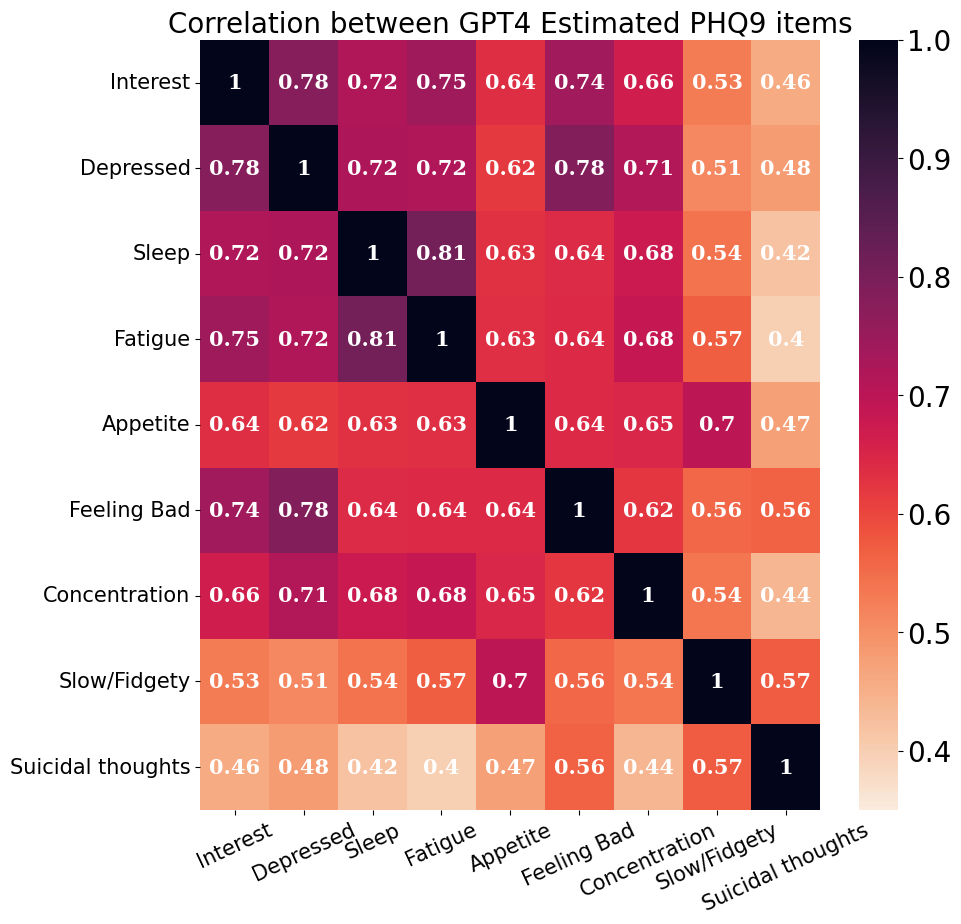

In [33]:
# Correlation in between all the items 
corr_df = parsed_response_df[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr().values
# Turn this into sns heatmap, with x axis label rotated 35 degrees, font size of the correlation values inside the heatmap as 20
plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr_df, annot=True, cmap='rocket_r', vmin=0.35, vmax=1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            })
plt.title('Correlation between GPT4 Estimated PHQ9 items', fontsize=20)
tick_pos = range(9)
tick_labels = ['Interest', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Feeling Bad', 'Concentration', 'Slow/Fidgety', 'Suicidal thoughts']
# ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels, rotation=25, fontsize=15)
ax.set_yticklabels(tick_labels, rotation=0, fontsize=15)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.show()
# save figure
# plt.savefig('./gpt4_item_corr.png', dpi=300, bbox_inches='tight')

In [34]:
corr_df = parsed_response_df[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr().values


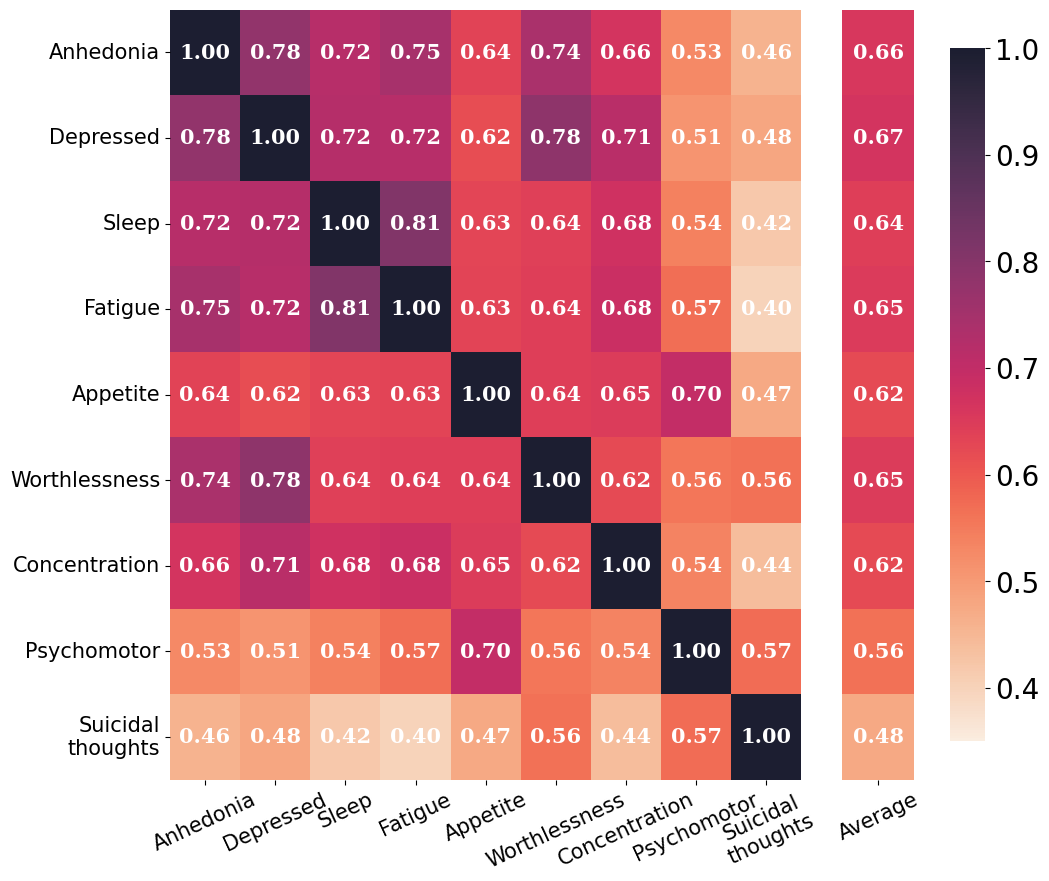

In [35]:
# Correlation in between all the items 
corr_df = parsed_response_df[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr().values
# Turn this into sns heatmap, with x axis label rotated 35 degrees, font size of the correlation values inside the heatmap as 20


f, (a0, a1) = plt.subplots(1, 2, figsize=(11, 10), gridspec_kw={'width_ratios': [3.5, 1], 'wspace': 0.1})


sns.heatmap(corr_df, annot=True, cmap='rocket_r', vmin=0.35, vmax=1, alpha=0.9, fmt='.2f',  annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, ax=a0, cbar=False)
tick_pos = range(9)
tick_labels = ['Anhedonia', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Worthlessness', 'Concentration', 'Psychomotor', 'Suicidal\nthoughts']
a0.set_xticklabels(tick_labels, rotation=25, fontsize=15)
a0.set_yticklabels(tick_labels, rotation=0, fontsize=15)

avgs = ((corr_df.sum(axis=1)-1.0)/8).reshape(-1, 1)
sns.heatmap(avgs, annot=True, cmap='rocket_r', vmin=0.35, vmax=1, alpha=0.9, fmt='.2f', ax=a1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, cbar_kws={'fraction': 0.4, 'shrink':0.9, 'pad': 0.2}, cbar=True)
a1.set_yticklabels([])
a1.tick_params(left=False)
a1.set_xticklabels(['Average'], rotation=25, fontsize=15)
cbar = a1.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)

# plt.savefig('./gpt4_item_corr.png', dpi=300, bbox_inches='tight')
plt.show()
# save figure


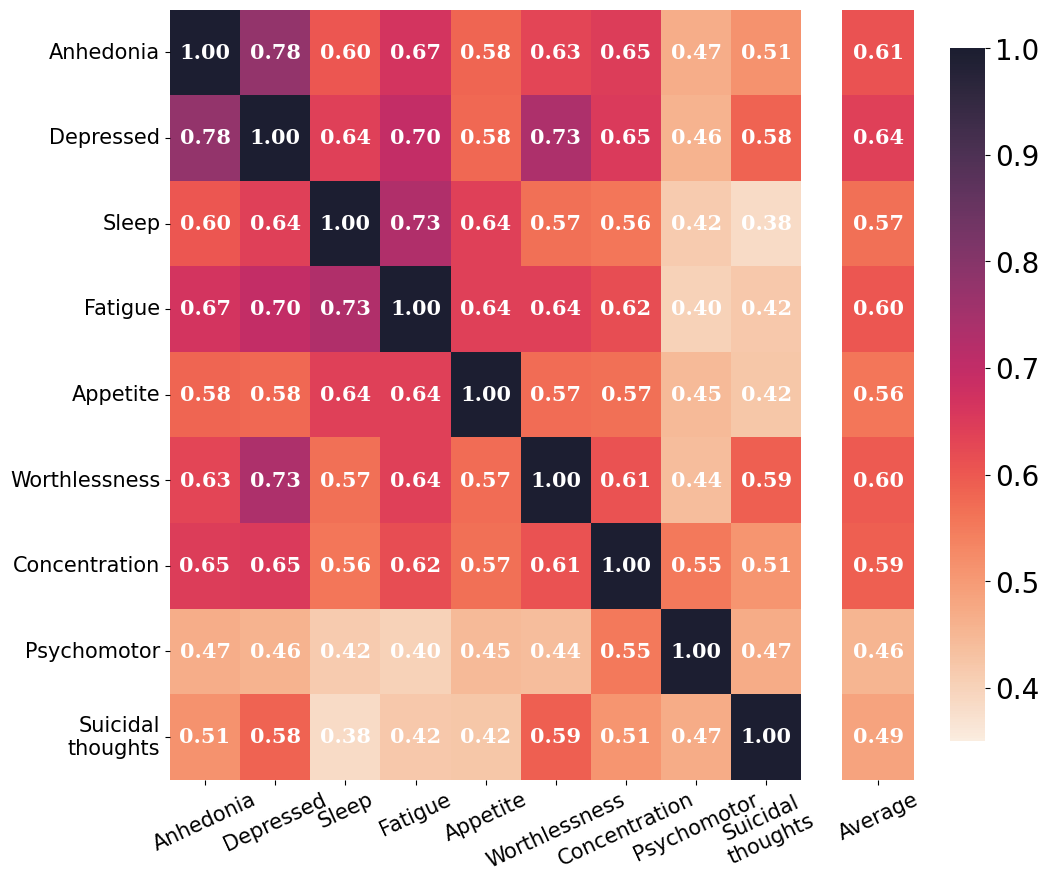

In [36]:
# Correlation in between all the items self reported  
corr_df = target_df[target_df.user_id.isin(parsed_response_df.user_id)][['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].rename(dict([(v, k) for k, v in PHQ_ITEM_COLUMN_MAPPING.items()])).corr().values

f, (a0, a1) = plt.subplots(1, 2, figsize=(11, 10), gridspec_kw={'width_ratios': [3.5, 1], 'wspace': 0.1})

sns.heatmap(corr_df, annot=True, cmap='rocket_r', vmin=0.35, vmax=1, alpha=0.9, fmt='.2f', annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, ax=a0, cbar=False)
tick_pos = range(9)
tick_labels = ['Anhedonia', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Worthlessness', 'Concentration', 'Psychomotor', 'Suicidal\nthoughts']
a0.set_xticklabels(tick_labels, rotation=25, fontsize=15)
a0.set_yticklabels(tick_labels, rotation=0, fontsize=15)

avgs = ((corr_df.sum(axis=1)-1.0)/8).reshape(-1, 1)
sns.heatmap(avgs, annot=True, cmap='rocket_r', vmin=0.35, vmax=1, alpha=0.9,fmt='.2f', ax=a1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, cbar_kws={'fraction': 0.4, 'shrink':0.9, 'pad': 0.2}, cbar=True)
a1.set_yticklabels([])
a1.tick_params(left=False)
a1.set_xticklabels(['Average'], rotation=25, fontsize=15)
cbar = a1.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)

# plt.savefig('./selfreport_item_corr.png', dpi=300, bbox_inches='tight')
plt.show()
# save figure


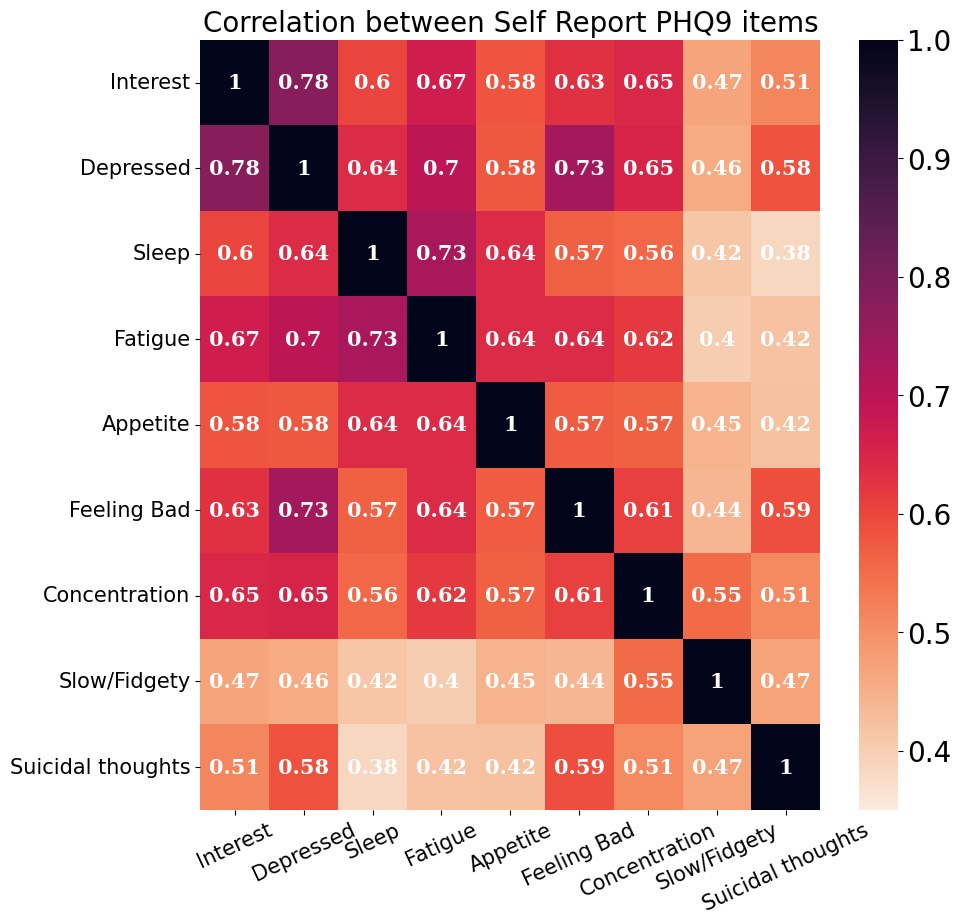

In [37]:
# Correlation in between all the items self reported  
corr_df = target_df[target_df.user_id.isin(parsed_response_df.user_id)][['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].rename(dict([(v, k) for k, v in PHQ_ITEM_COLUMN_MAPPING.items()])).corr()
# Turn this into sns heatmap, with x axis label rotated 35 degrees
plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr_df, annot=True, cmap='rocket_r', vmin=0.35, vmax=1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            })
plt.title('Correlation between Self Report PHQ9 items', fontsize=20)
tick_pos = range(9)
tick_labels = ['Interest', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Feeling Bad', 'Concentration', 'Slow/Fidgety', 'Suicidal thoughts']
# ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels, rotation=25, fontsize=15)
ax.set_yticklabels(tick_labels, rotation=0, fontsize=15)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.show()

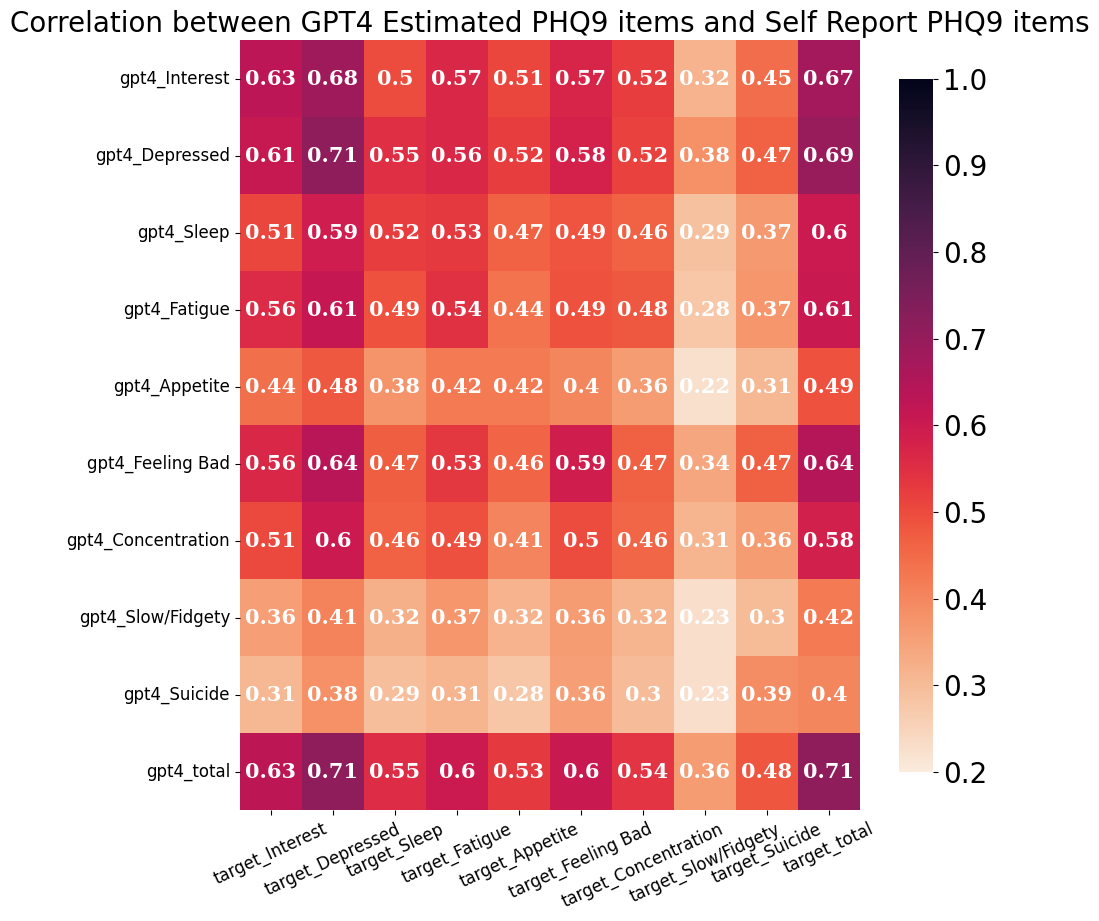

In [38]:

corr_df = np.zeros((10, 10))
x_y = pd.merge(parsed_response_df[['user_id']+['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]], target_df[['user_id']+['{}'.format(j) for j in PHQ_ITEM_COLUMN_MAPPING.values()]], on='user_id')
# Correlate the GPT4 estimated items with self reported items
x_y['score_total'] = x_y[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].sum(1)
x_y['target_total'] = x_y[['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].sum(1)

rows = list(PHQ_ITEM_COLUMN_MAP.values()) + ['total']
cols = list(PHQ_ITEM_COLUMN_MAPPING.values()) + ['target_total']

for i,col_i in enumerate(rows):
    x = x_y['score_{}'.format(col_i)]
    for j,col_j in enumerate(cols):
        y = x_y[col_j]
        corr_df[i][j] = pearsonr(x.values, y.values)[0]

plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr_df, annot=True, cmap='rocket_r', vmin=0.20, vmax=1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, cbar_kws={'shrink': 0.9})
# plt.title('Correlation between GPT4 Estimated PHQ9 items', fontsize=20)
tick_pos = range(10)
tick_labels = ['Interest', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Feeling Bad', 'Concentration', 'Slow/Fidgety', 'Suicide', 'total']
plt.title('Correlation between GPT4 Estimated PHQ9 items and Self Report PHQ9 items', fontsize=20)
# ax.set_xticks([i+0.15 for i in range(9)] + [9.75])
ax.set_yticklabels(['gpt4_{}'.format(i) for i in tick_labels], rotation=0, fontsize=12)
ax.set_xticklabels(['target_{}'.format(i) for i in tick_labels], rotation=25, fontsize=12)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.show()
# savefig to ./data/gpt4_selfreport_item_corr.png


In [39]:
print(sns.color_palette("coolwarm").as_hex())

['#6788ee', '#9abbff', '#c9d7f0', '#edd1c2', '#f7a889', '#e26952']


In [40]:
sns.color_palette(['#5b82fc', '#9abbff', '#acb4c2', '#edd1c2', '#f7a889', '#f76c52'], as_cmap=True)

['#5b82fc', '#9abbff', '#acb4c2', '#edd1c2', '#f7a889', '#f76c52']

In [41]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as clr

# https://stackoverflow.com/questions/38147997/how-to-change-a-linearsegmentedcolormap-to-a-different-distribution-of-color
clrs = list(map(lambda x: (x[0]/8.0, x[1]), enumerate(['#5a77d1', '#6788ee', '#9abbff', '#c9d7f0', '#8c93a1', '#edd1c2', '#f7a889', '#e26952', '#c95a44'])))
clrs = list(map(lambda x: (x[0]/6.0, x[1]), enumerate(['#5a77d1', '#6788ee', '#9abbff', '#a9aaab', '#f7a889', '#e26952', '#c95a44'])))
# clrs = list(map(lambda x: (x[0]/7.0, x[1]), enumerate(['#5a77d1', '#9abbff', '#c9d7f0', '#aeb9cf', '#edd1c2', '#f7a889', '#e26952', '#c95a44'])))

custom_cmap = clr.LinearSegmentedColormap.from_list('custom coolwarm', clrs, N=256)

# cmap = {obsv_id:np.random.random() for obsv_id in range(9)}
# sm = ScalarMappable(norm=Normalize(vmin=min(list(cmap.values())), vmax=max(list(cmap.values()))), cmap=sns.cubehelix_palette(as_cmap=True))


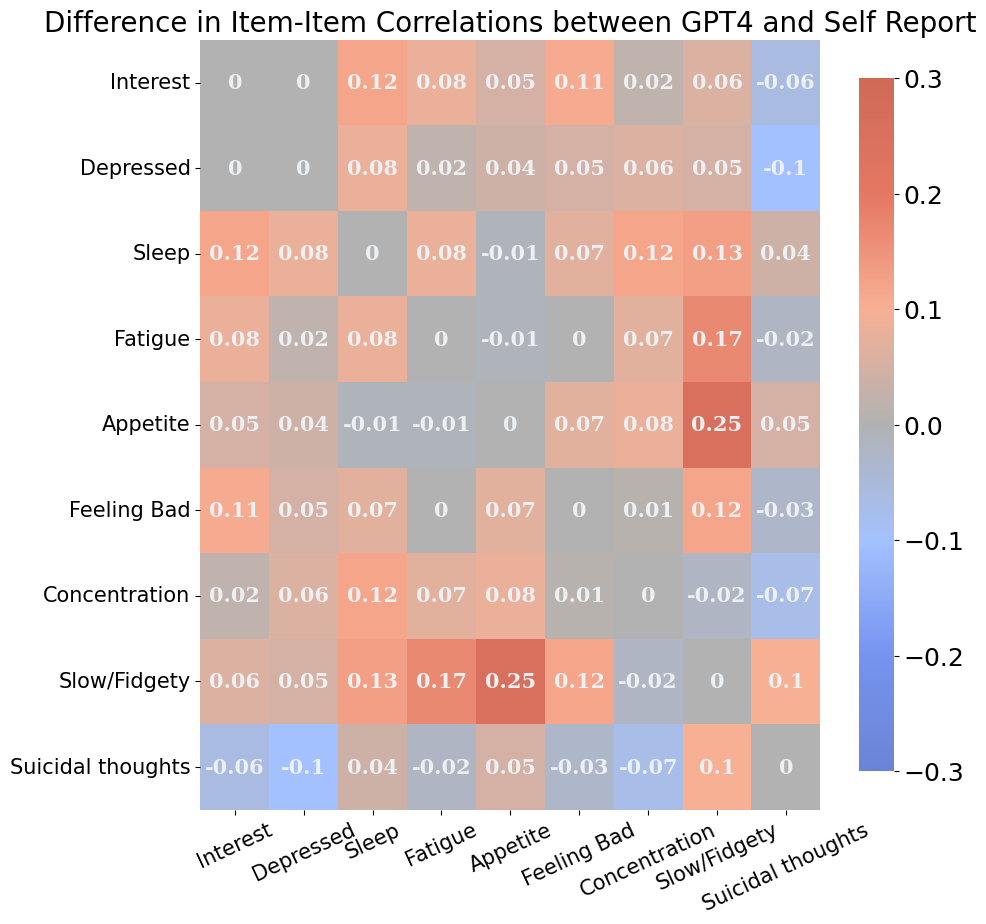

In [42]:
# Difference between GPT4 estimated items correlations and Self report items correlations

# gpt4_items_corr = parsed_response_df[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr()
gpt4_items_corr = x_y[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr()
selfreport_items_corr = x_y[['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].corr()

# selfreport_items_corr = target_df[target_df.user_id.isin(parsed_response_df.user_id)][['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].rename(dict([(v, k) for k, v in PHQ_ITEM_COLUMN_MAPPING.items()])).corr()

diff_corr = np.round(gpt4_items_corr.values - selfreport_items_corr.values, 2)

# Turn this into sns heatmap, with x axis label rotated 35 degrees
plt.figure(figsize=(10, 10))
ax = sns.heatmap(diff_corr, annot=True, cmap=custom_cmap, vmin=-0.3, vmax=0.3, alpha=0.90, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': '#edf0f2',
                'alpha': 1
            }, cbar_kws={'shrink': 0.9})
plt.title('Difference in Item-Item Correlations between GPT4 and Self Report', fontsize=20)
tick_pos = range(9)
tick_labels = ['Interest', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Feeling Bad', 'Concentration', 'Slow/Fidgety', 'Suicidal thoughts']
# ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels, rotation=25, fontsize=15)
ax.set_yticklabels(tick_labels, rotation=0, fontsize=15)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=18)
plt.show()


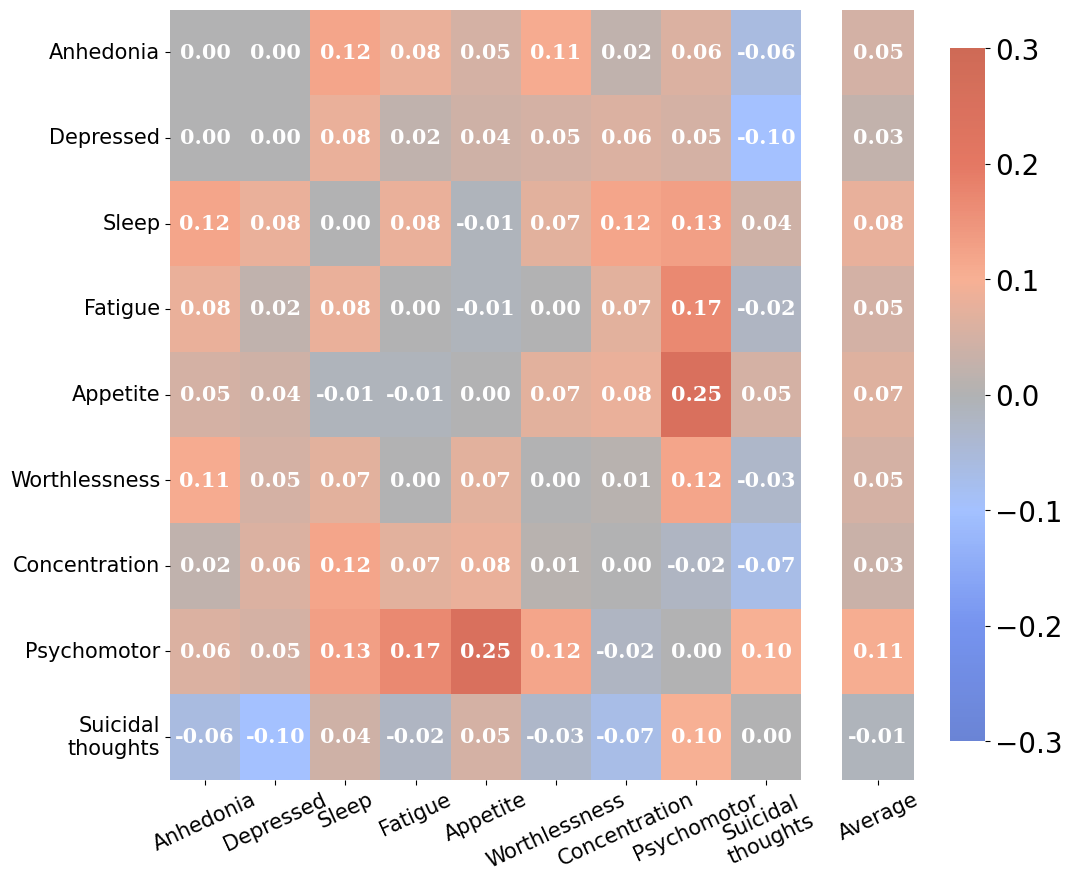

In [43]:
# Difference between GPT4 estimated items correlations and Self report items correlations

# gpt4_items_corr = parsed_response_df[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr()
gpt4_items_corr = x_y[['score_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].corr()
selfreport_items_corr = x_y[['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].corr()

# selfreport_items_corr = target_df[target_df.user_id.isin(parsed_response_df.user_id)][['{}'.format(i) for i in PHQ_ITEM_COLUMN_MAPPING.values()]].rename(dict([(v, k) for k, v in PHQ_ITEM_COLUMN_MAPPING.items()])).corr()

diff_corr = np.round(gpt4_items_corr.values - selfreport_items_corr.values, 2)

f, (a0, a1) = plt.subplots(1, 2, figsize=(11, 10), gridspec_kw={'width_ratios': [3.5, 1], 'wspace': 0.1})

sns.heatmap(diff_corr, annot=True,cmap=custom_cmap,vmin=-0.3, vmax=0.3, alpha=0.90, fmt='.2f', annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, ax=a0, cbar=False)
tick_pos = range(9)
tick_labels = ['Anhedonia', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Worthlessness', 'Concentration', 'Psychomotor', 'Suicidal\nthoughts']
a0.set_xticklabels(tick_labels, rotation=25, fontsize=15)
a0.set_yticklabels(tick_labels, rotation=0, fontsize=15)

avgs = (diff_corr.mean(axis=1)*9/8.0).reshape(-1, 1)
sns.heatmap(avgs, annot=True, cmap=custom_cmap, vmin=-0.3, vmax=0.3, alpha=0.90, fmt='.2f', ax=a1, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white'
            }, cbar_kws={'fraction': 0.4, 'shrink':0.9, 'pad': 0.2}, cbar=True)
a1.set_yticklabels([])
a1.tick_params(left=False)
a1.set_xticklabels(['Average'], rotation=25, fontsize=15)
cbar = a1.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)

# plt.savefig('./diff_gpt4_sr_item_corr.png', dpi=300, bbox_inches='tight')
plt.show()
# save figure

In [44]:
# Run cohen's d on the GPT4 and expert avg
from numpy import mean, var, std
from math import sqrt
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*var(x, ddof=1)+(ny-1)*var(y, ddof=1)) / dof)

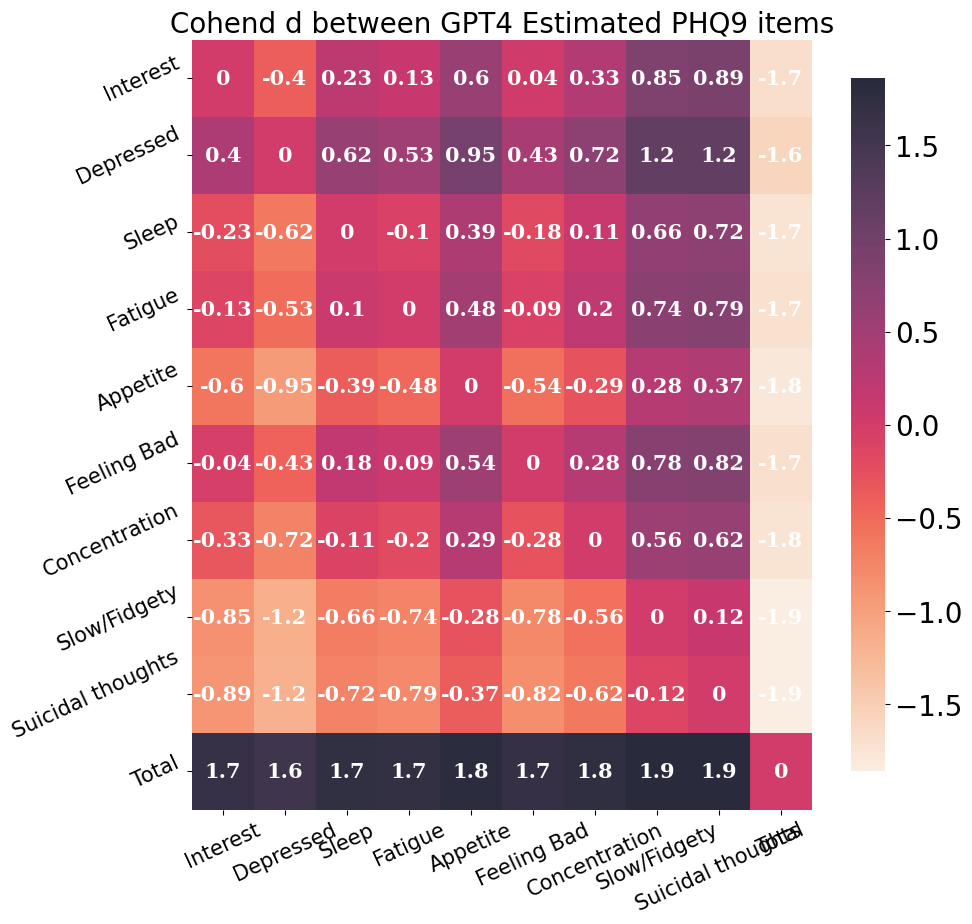

In [45]:
# Calculate Cohen's d for all pairs of GPT4 estimated symptoms scores
gpt4_cohensd = np.zeros((10, 10))
for i,col_i in enumerate(rows):
    x = x_y['score_{}'.format(col_i)]
    for j,col_j in enumerate(rows):
        y = x_y['score_{}'.format(col_j)]
        gpt4_cohensd[i][j] = cohen_d(x.values, y.values)

plt.figure(figsize=(10, 10))
ax = sns.heatmap(gpt4_cohensd.round(2), annot=True, cmap='rocket_r', alpha=0.85, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': 'white', 'alpha':1
            }, cbar_kws={'shrink': 0.9})
# plt.title('Correlation between GPT4 Estimated PHQ9 items', fontsize=20)
tick_pos = range(10)
plt.title('Cohend d between GPT4 Estimated PHQ9 items', fontsize=20)
tick_labels = ['Interest', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Feeling Bad', 'Concentration', 'Slow/Fidgety', 'Suicidal thoughts', 'Total']
# ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels, rotation=25, fontsize=15)
ax.set_yticklabels(tick_labels, rotation=25, fontsize=15)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.show()


In [46]:
# Correlating PHQ2
x = x_y[['score_Lack_of_interest', 'score_Feeling_depressed']].values
y = x_y[['target_Lack_of_interest', 'target_Feeling_depressed']].values
gpt4_selfreport_phq2_pearsonr, p_val = pearsonr(x.sum(1), y.sum(1))
print ("Correlation between GPT4 and Self report on PHQ2: {} (p={})".format(round(gpt4_selfreport_phq2_pearsonr, 3), round(p_val, 3)))

Correlation between GPT4 and Self report on PHQ2: 0.739 (p=0.0)


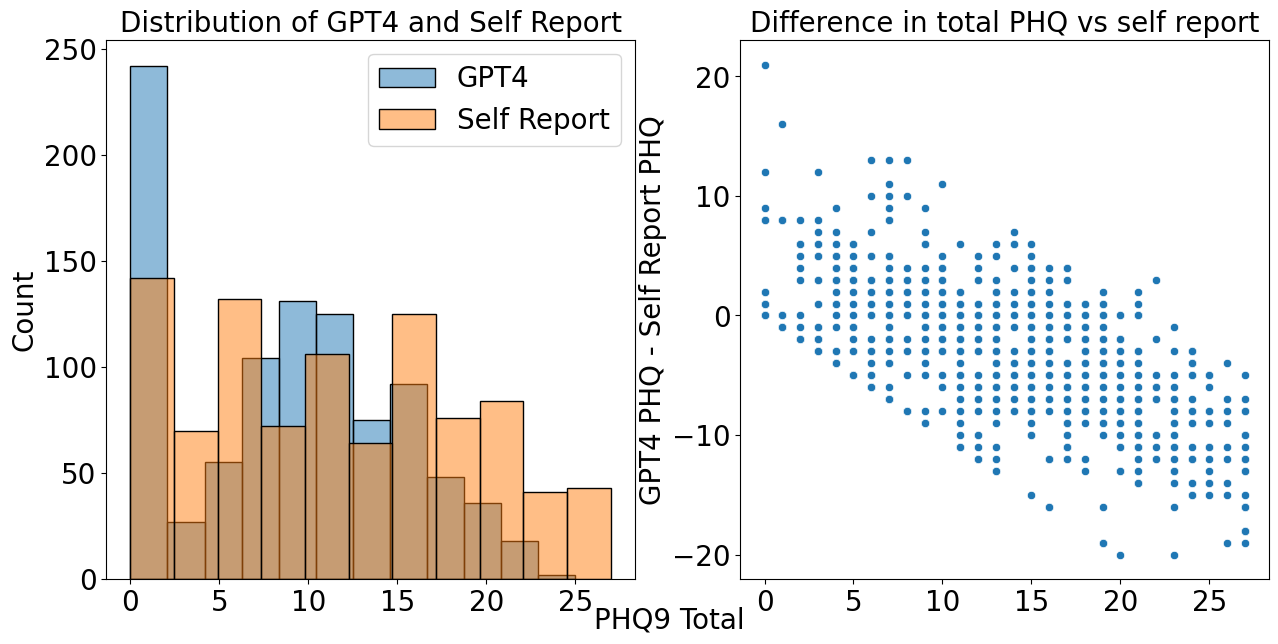

In [47]:
# Plot the Distribution of GPT4 total PHQ9 and self report PHQ9 total
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
x = parsed_response_df[score_columns].sum(1).values
y = parsed_response_df.target_value.values
sns.histplot(x, label='GPT4', alpha=0.5, ax=axs[0])
sns.histplot(y, label='Self Report', alpha=0.5, ax=axs[0])
axs[0].set_title('Distribution of GPT4 and Self Report', fontsize=20)
axs[0].legend(fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_ylabel('Count', fontsize=20)

# Plot of error in GPT4 and Self report PHQ9 total vs Self report PHQ9 total
y = (parsed_response_df[score_columns].sum(1) - parsed_response_df.target_value).values
x = parsed_response_df.target_value.values
sns.scatterplot(x=x, y=y, ax=axs[1])
axs[1].set_title('Difference in total PHQ vs self report', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
# set the x-axis label
axs[1].set_ylabel('GPT4 PHQ - Self Report PHQ', fontsize=20)

# Set common y label as PHQ9 total
fig.text(0.5, 0.04, 'PHQ9 Total', ha='center', fontsize=20)
plt.show()

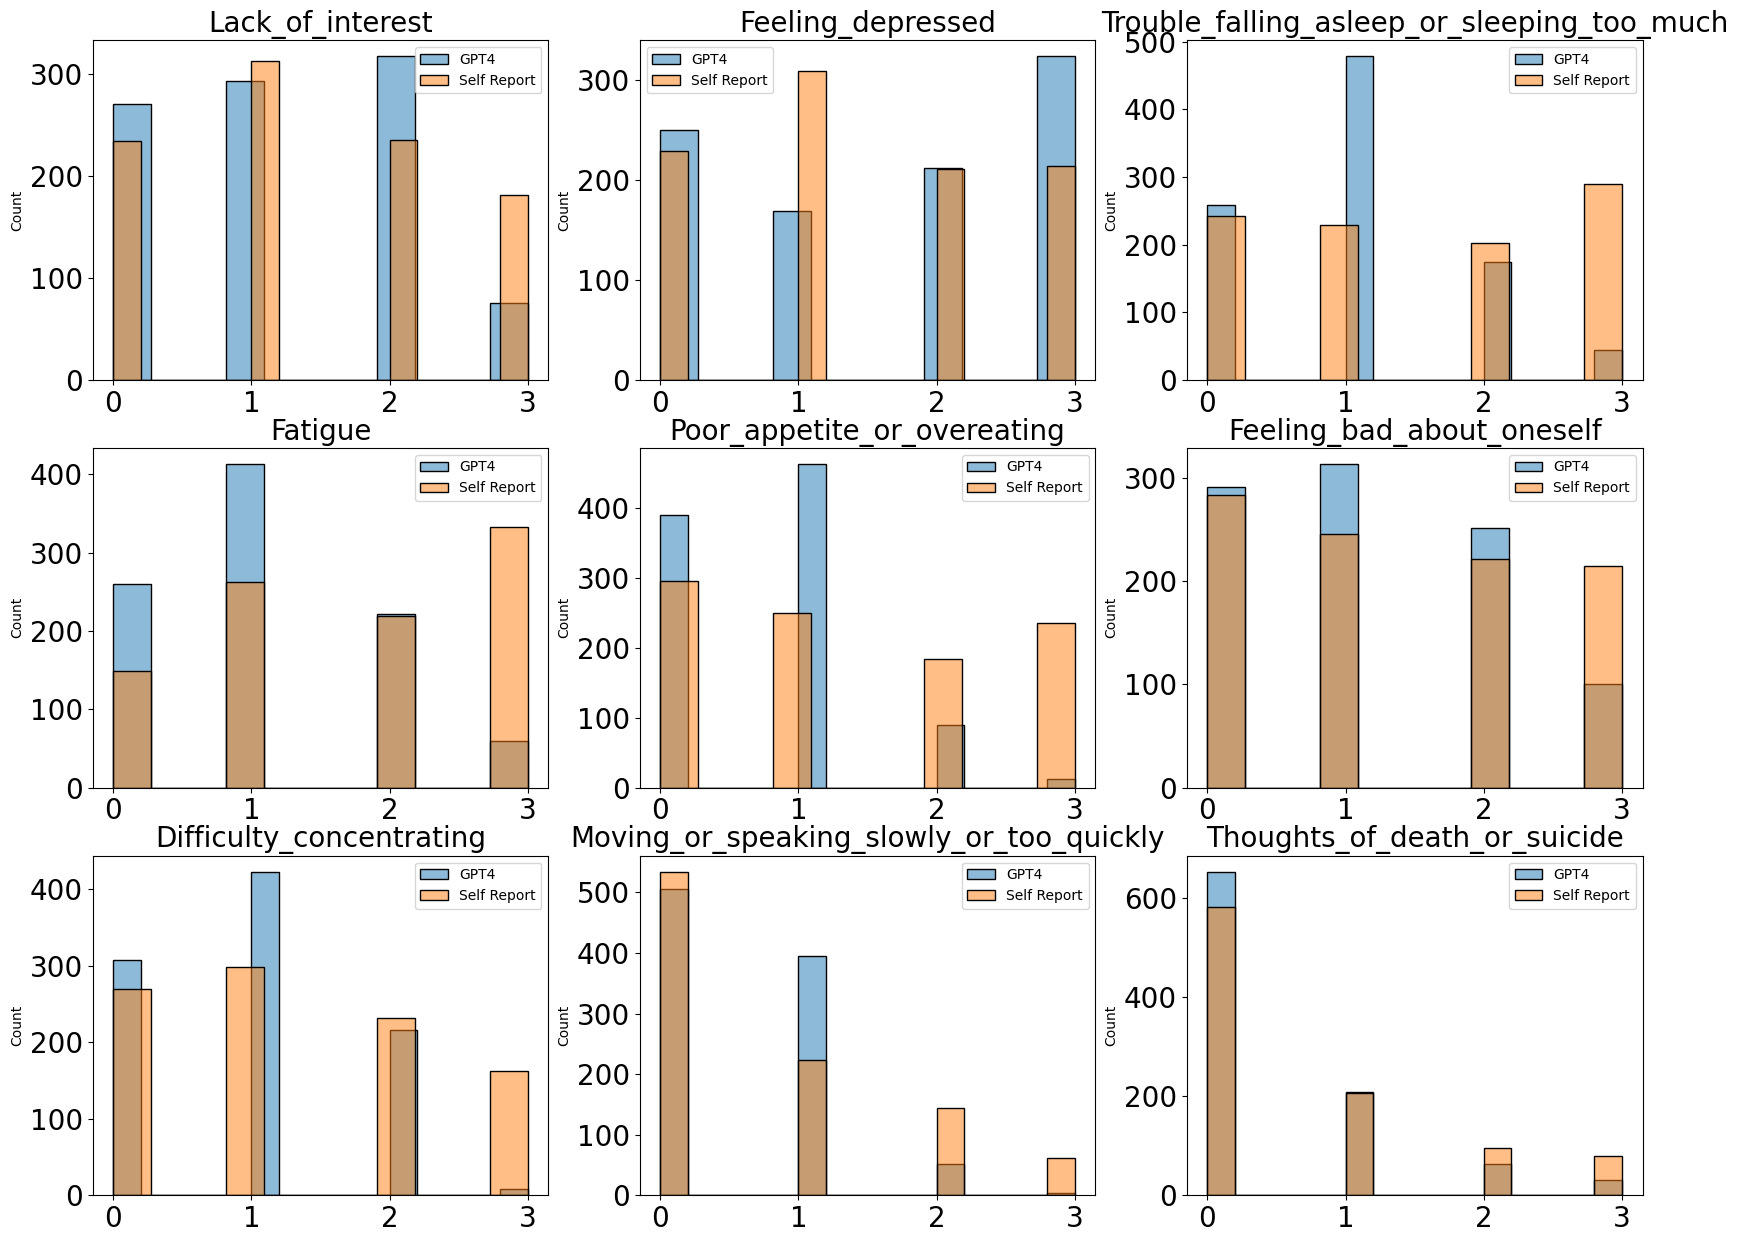

In [48]:
# Create a 3x3 grid of plots, with each plot showing the distribution of GPT4 estimated score for each item and self report score for each item
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
for i, ax in enumerate(axs.flatten()):
    sns.histplot(parsed_response_df['score_{}'.format(list(PHQ_ITEM_COLUMN_MAP.values())[i])].values, ax=ax, alpha=0.5, label='GPT4')
    sns.histplot(target_df['target_{}'.format(list(PHQ_ITEM_COLUMN_MAP.values())[i])].values, ax=ax, alpha=0.5, label="Self Report")
    ax.set_title(list(PHQ_ITEM_COLUMN_MAP.values())[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(fontsize=10)
    
plt.show()

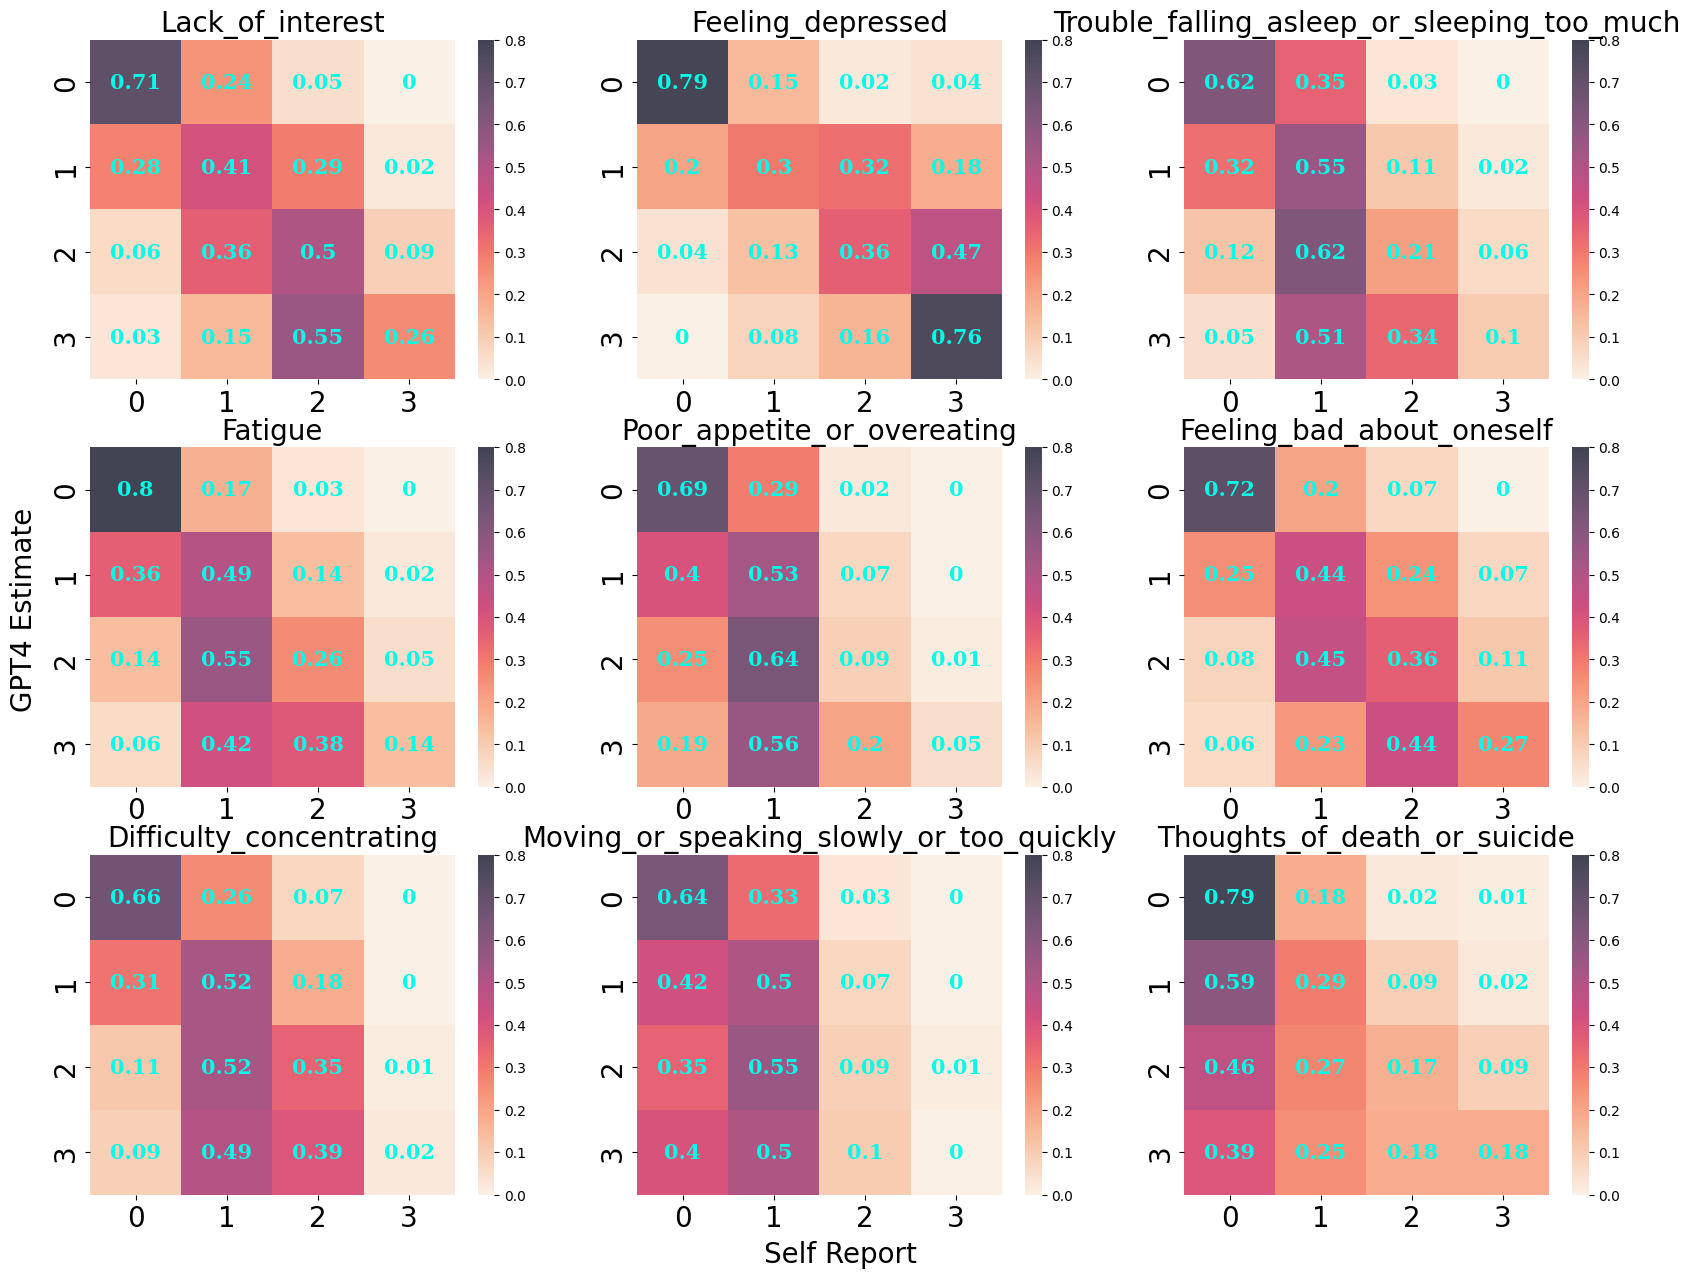

In [50]:
# Create a 3x3 grid of plots, with each plot showing scatter plot of error in GPT4 estimated score for each item and self report score for each item
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
for i, ax in enumerate(axs.flatten()):
    y = x_y['score_{}'.format(list(PHQ_ITEM_COLUMN_MAP.values())[i])].values 
    x = x_y['{}'.format(list(PHQ_ITEM_COLUMN_MAPPING.values())[i])].values
    sns.heatmap((confusion_matrix(y_pred=y, y_true=x, normalize='true')).round(2), annot=True, cmap='rocket_r', ax=ax, vmin=-0.0, vmax=0.8, alpha=0.75, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': '#03fce8'
            })      
    # sns.scatterplot(x=x, y=y, ax=ax)
    ax.set_title(list(PHQ_ITEM_COLUMN_MAP.values())[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    # ax.legend(fontsize=10)
# add common x axis and y axis label as self report and GPT4
fig.text(0.5, 0.065, 'Self Report', ha='center', fontsize=20)
fig.text(0.085, 0.5, 'GPT4 Estimate', va='center', rotation='vertical', fontsize=20)
plt.show()


In [53]:
PHQ_ITEM_COLUMN_MAP

{'PHQ.SQ01.': 'Lack_of_interest',
 'PHQ.SQ02.': 'Feeling_depressed',
 'PHQ.SQ03.': 'Trouble_falling_asleep_or_sleeping_too_much',
 'PHQ.SQ04.': 'Fatigue',
 'PHQ.SQ05.': 'Poor_appetite_or_overeating',
 'PHQ.SQ06.': 'Feeling_bad_about_oneself',
 'PHQ.SQ07.': 'Difficulty_concentrating',
 'PHQ.SQ08.': 'Moving_or_speaking_slowly_or_too_quickly',
 'PHQ.SQ09.': 'Thoughts_of_death_or_suicide'}

In [66]:
PHQ_ITEM_COLUMN_MAP2 = {i: PHQ_ITEM_COLUMN_MAP[i] for i in ['PHQ.SQ01.', 'PHQ.SQ02.', 'PHQ.SQ03.', 'PHQ.SQ06.', 'PHQ.SQ09.', 'PHQ.SQ04.', 'PHQ.SQ08.', 'PHQ.SQ05.', 'PHQ.SQ07.']}
PHQ_ITEM_COLUMN_MAPPING2 = {i: PHQ_ITEM_COLUMN_MAPPING[i] for i in ['PHQ.SQ01.', 'PHQ.SQ02.', 'PHQ.SQ03.', 'PHQ.SQ06.', 'PHQ.SQ09.', 'PHQ.SQ04.', 'PHQ.SQ08.', 'PHQ.SQ05.', 'PHQ.SQ07.']}
PHQ_ITEM_COLUMN_MAP2_LABEL = {}
PHQ_ITEM_COLUMN_MAP2_LABEL['PHQ.SQ01.'] = 'Anhedonia'
PHQ_ITEM_COLUMN_MAP2_LABEL['PHQ.SQ02.'] = 'Depressed'
PHQ_ITEM_COLUMN_MAP2_LABEL['PHQ.SQ03.'] = 'Sleep'
PHQ_ITEM_COLUMN_MAP2_LABEL['PHQ.SQ06.'] = 'Worthlessness'
PHQ_ITEM_COLUMN_MAP2_LABEL['PHQ.SQ09.'] = 'Suicidal Thoughts'
PHQ_ITEM_COLUMN_MAP2_LABEL['PHQ.SQ04.'] = 'Fatigue'
PHQ_ITEM_COLUMN_MAP2_LABEL['PHQ.SQ08.'] = 'Psychomotor'
PHQ_ITEM_COLUMN_MAP2_LABEL['PHQ.SQ05.'] = 'Appetite'
PHQ_ITEM_COLUMN_MAP2_LABEL['PHQ.SQ07.'] = 'Concentration'

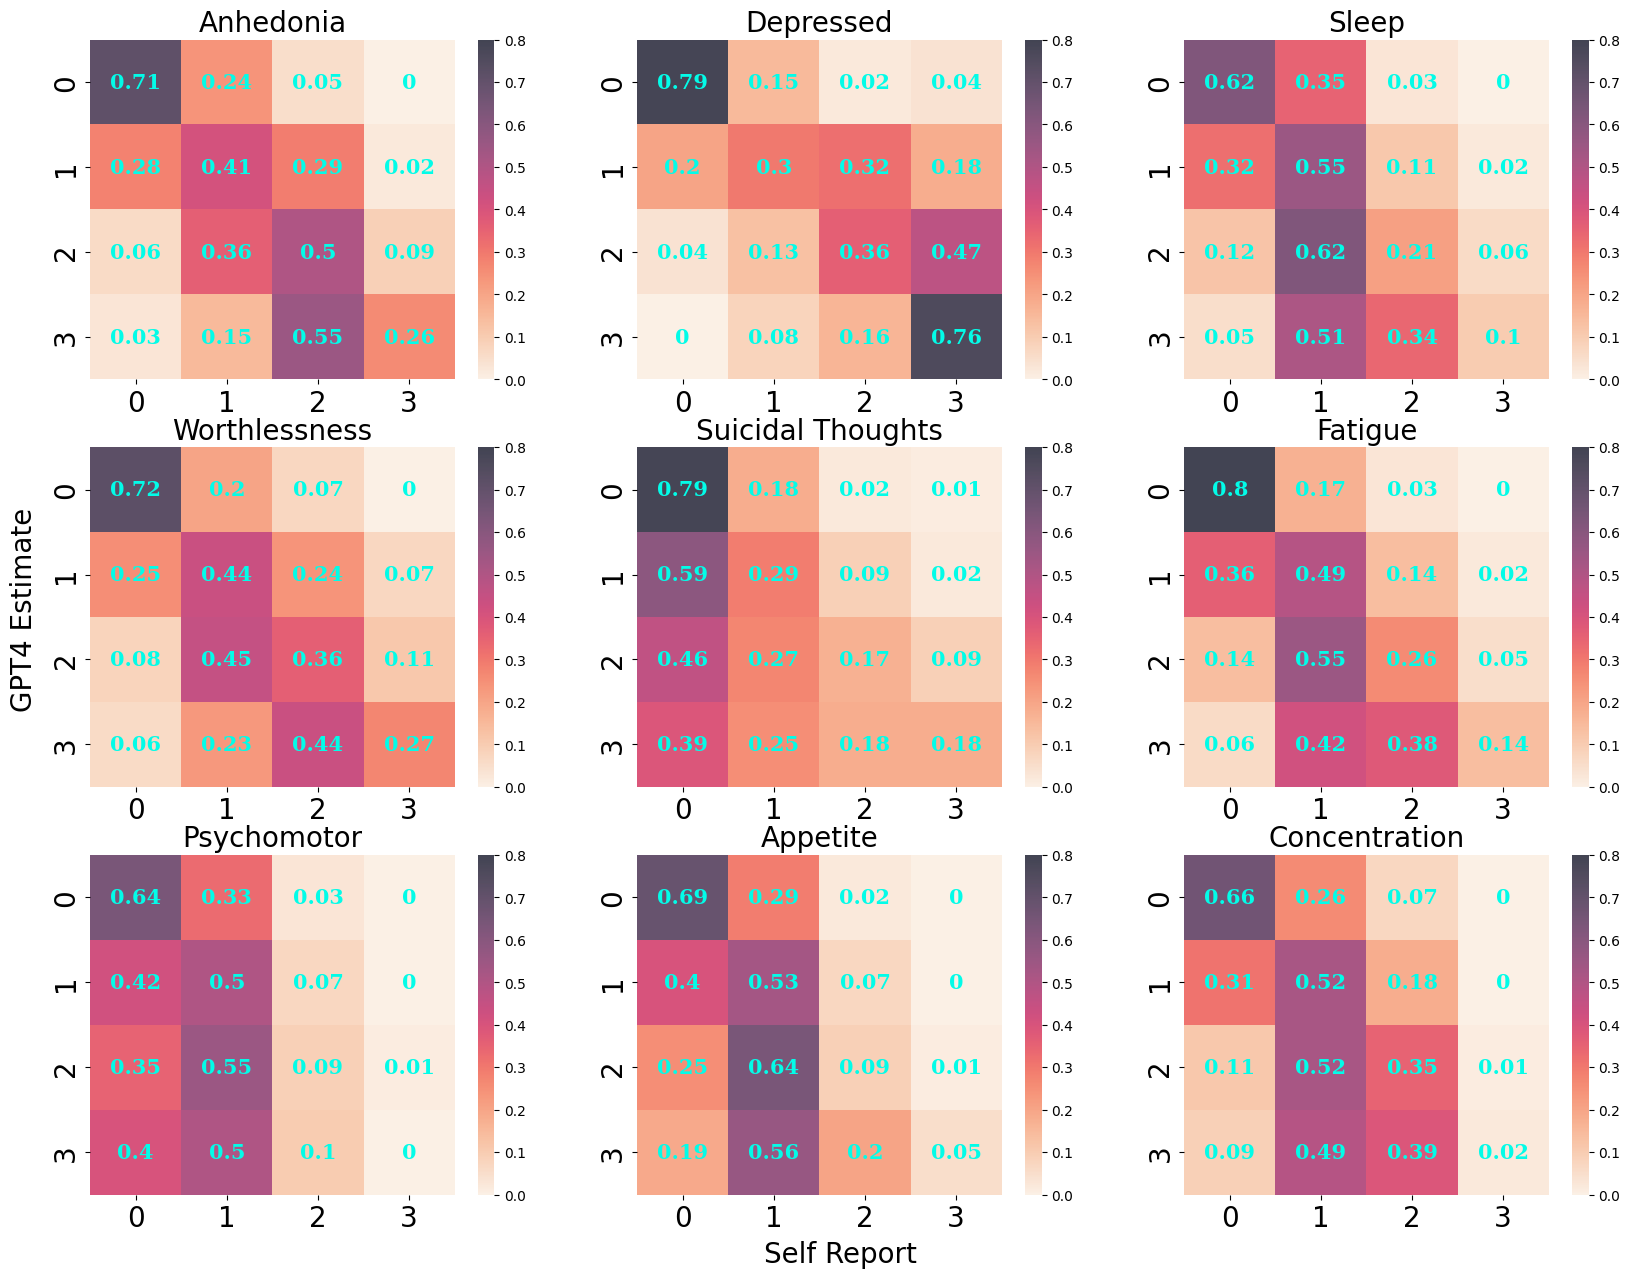

In [67]:
# Create a 3x3 grid of plots, with each plot showing scatter plot of error in GPT4 estimated score for each item and self report score for each item
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
for i, ax in enumerate(axs.flatten()):
    y = x_y['score_{}'.format(list(PHQ_ITEM_COLUMN_MAP2.values())[i])].values 
    x = x_y['{}'.format(list(PHQ_ITEM_COLUMN_MAPPING2.values())[i])].values
    sns.heatmap((confusion_matrix(y_pred=y, y_true=x, normalize='true')).round(2), annot=True, cmap='rocket_r', ax=ax, vmin=-0.0, vmax=0.8, alpha=0.75, annot_kws={
                'fontsize': 15,
                'fontweight': 'bold',
                'fontfamily': 'serif',
                'color': '#03fce8'
            })
    # sns.scatterplot(x=x, y=y, ax=ax)
    ax.set_title(list(PHQ_ITEM_COLUMN_MAP2_LABEL.values())[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    # ax.legend(fontsize=10)
# add common x axis and y axis label as self report and GPT4
fig.text(0.5, 0.065, 'Self Report', ha='center', fontsize=20)
fig.text(0.085, 0.5, 'GPT4 Estimate', va='center', rotation='vertical', fontsize=20)
plt.savefig('./gpt4_sr_item_dist.png', dpi=300, bbox_inches='tight')
plt.show()



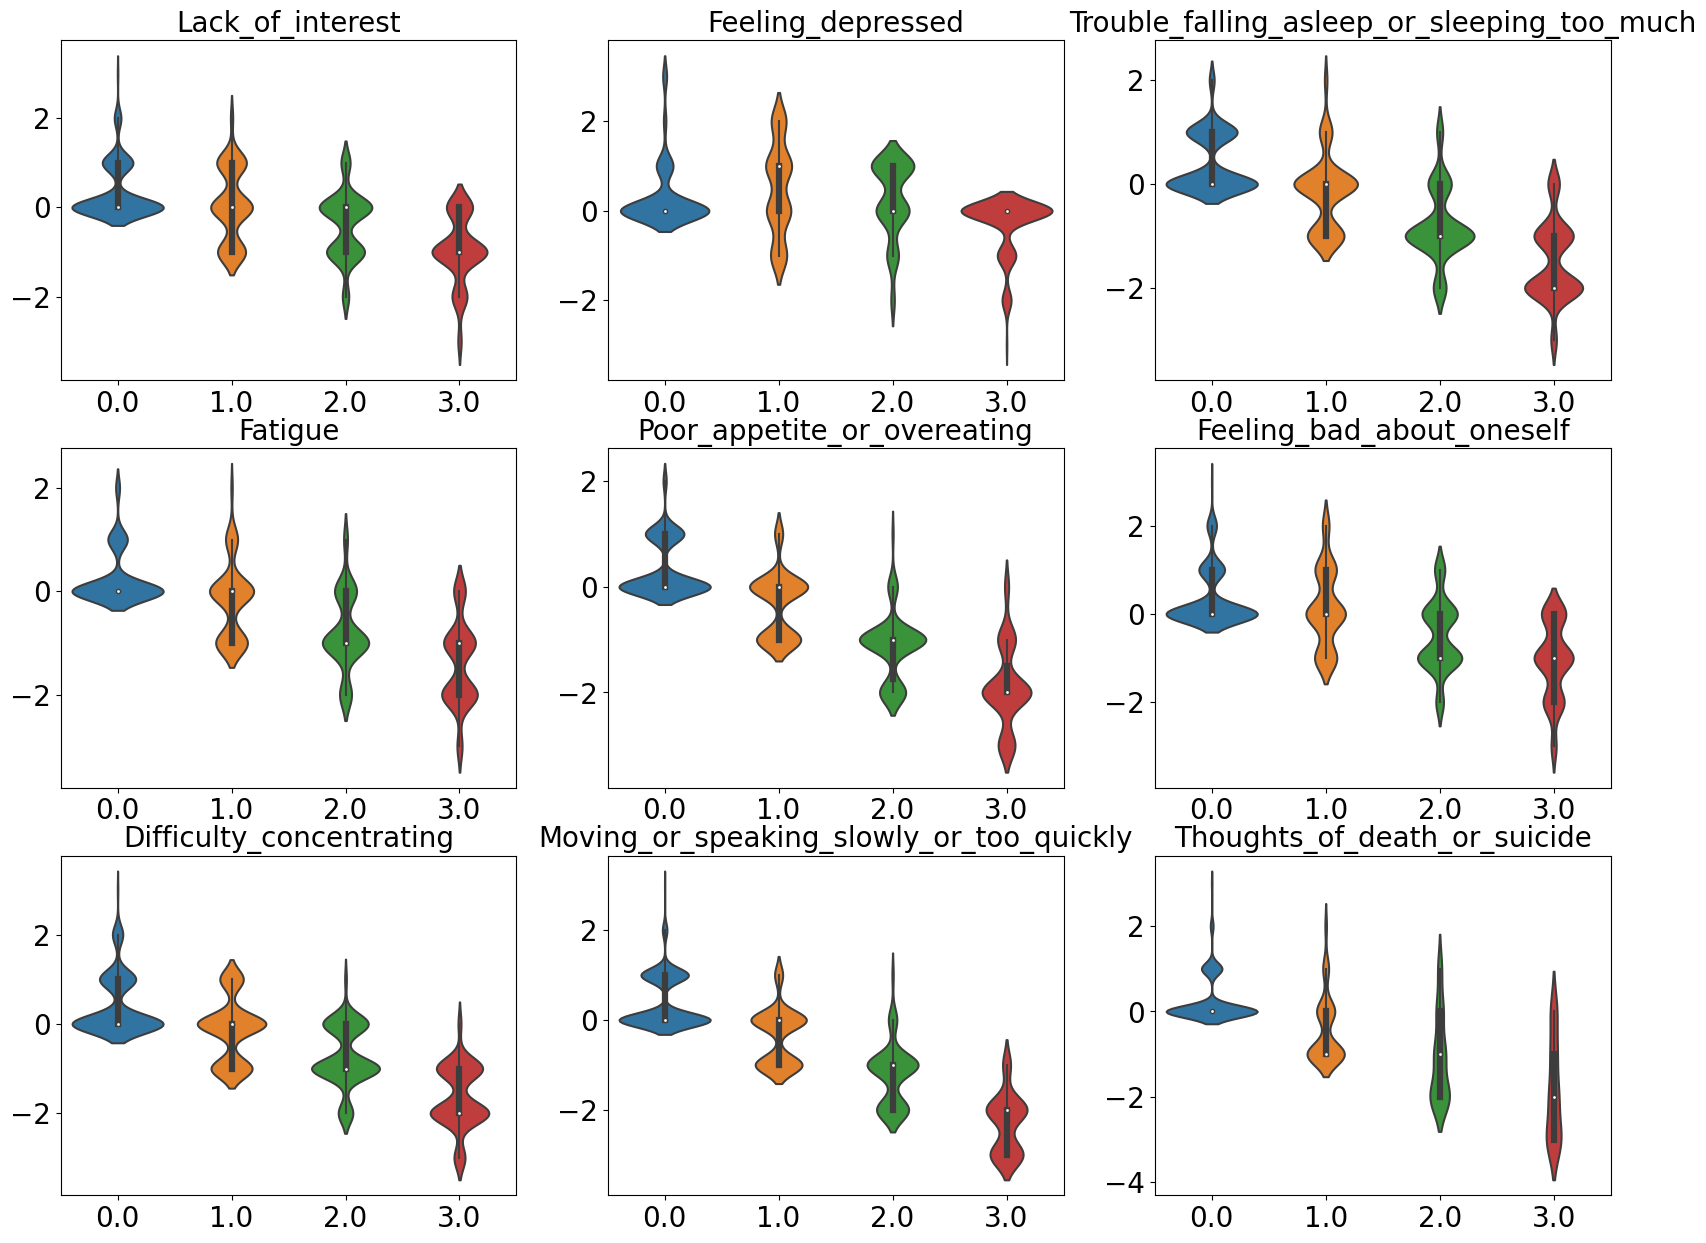

In [87]:
# Create a 3x3 grid of plots, with each plot showing scatter plot of error in GPT4 estimated score for each item and self report score for each item
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
for i, ax in enumerate(axs.flatten()):
    y = x_y['score_{}'.format(list(PHQ_ITEM_COLUMN_MAP.values())[i])].values - x_y['{}'.format(list(PHQ_ITEM_COLUMN_MAPPING.values())[i])].values
    x = x_y['{}'.format(list(PHQ_ITEM_COLUMN_MAPPING.values())[i])].values
    # make violin plot of the error in GPT4 estimated score for each item and self report score for each item
    sns.violinplot(x=x, y=y, ax=ax)
    # sns.scatterplot(x=x, y=y, ax=ax)
    ax.set_title(list(PHQ_ITEM_COLUMN_MAP.values())[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    # ax.legend(fontsize=10)
plt.show()

In [40]:
# Text legth vs depression score
word_counts = target_df[target_df.user_id.isin(parsed_response_df.user_id)].dep_text.apply(lambda x: len(x.split())) 
distinct_word_counts = target_df[target_df.user_id.isin(parsed_response_df.user_id)].dep_text.apply(lambda x: len(set(x.split())))
character_counts = target_df[target_df.user_id.isin(parsed_response_df.user_id)].dep_text.apply(lambda x: len(x) - len(x.replace(' ', '')))
dep_score = target_df[target_df.user_id.isin(parsed_response_df.user_id)].phq_score 
word_counts_pearsonr, p_val = pearsonr(word_counts, dep_score)
print ("Correlation between word counts and depression score: {} (p={})".format(round(word_counts_pearsonr, 3), round(p_val, 3)))
distinct_word_counts_pearsonr, p_val = pearsonr(distinct_word_counts, dep_score)
print ("Correlation between distinct word counts and depression score: {} (p={})".format(round(distinct_word_counts_pearsonr, 3), round(p_val, 3)))

Correlation between word counts and depression score: 0.136 (p=0.0)
Correlation between distinct word counts and depression score: 0.155 (p=0.0)


In [41]:
# Check if predictions are more accurate when the length is longer
temp_df = pd.merge(parsed_response_df, target_df[['user_id', 'dep_text']], on='user_id')
gpt4_error = temp_df['target_value'] - temp_df[score_columns].sum(1)
distinct_word_count = temp_df['dep_text'].apply(lambda x: len(set(x.split())))
word_count = temp_df['dep_text'].apply(lambda x: len(x.split()))

error_wc_pearsonr, p_val = pearsonr(gpt4_error, word_count)
print ("Correlation between GPT4 error and word count: {} (p={})".format(round(error_wc_pearsonr, 3), round(p_val, 3)))
abs_error_wc_pearsonr, p_val = pearsonr(np.abs(gpt4_error), word_count)
print ("Correlation between GPT4 abs error and word count: {} (p={})".format(round(abs_error_wc_pearsonr, 3), round(p_val, 3)))

error_dwc_pearsonr, p_val = pearsonr(gpt4_error, distinct_word_count)
print ("Correlation between GPT4 error and distinct word count: {} (p={})".format(round(error_dwc_pearsonr, 3), round(p_val, 3)))
abs_error_dwc_pearsonr, p_val = pearsonr(np.abs(gpt4_error), distinct_word_count)
print ("Correlation between GPT4 abs error and distinct word count: {} (p={})".format(round(abs_error_dwc_pearsonr, 3), round(p_val, 3)))


Correlation between GPT4 error and word count: -0.04 (p=0.219)
Correlation between GPT4 abs error and word count: -0.043 (p=0.179)
Correlation between GPT4 error and distinct word count: -0.044 (p=0.172)
Correlation between GPT4 abs error and distinct word count: -0.039 (p=0.229)


In [42]:
flesch_reading_ease = temp_df.dep_text.apply(lambda x: textstat.flesch_reading_ease(x))
flesch_kincaid_grade = temp_df.dep_text.apply(lambda x: textstat.flesch_kincaid_grade(x))
syllable_count = temp_df.dep_text.apply(lambda x: textstat.syllable_count(x))
lexicon_count = temp_df.dep_text.apply(lambda x: textstat.lexicon_count(x, removepunct=True))
poly_syllable_count = temp_df.dep_text.apply(lambda x: textstat.polysyllabcount(x))
mono_syllable_count = temp_df.dep_text.apply(lambda x: textstat.monosyllabcount(x))

# combine all the above with temp_df and correlate gpt4 prediction score, target_value and gpt's error with these metrics
temp_df['flesch_reading_ease'] = flesch_reading_ease
temp_df['flesch_kincaid_grade'] = flesch_kincaid_grade
temp_df['syllable_count'] = syllable_count
temp_df['lexicon_count'] = lexicon_count
temp_df['poly_syllable_count'] = poly_syllable_count
temp_df['mono_syllable_count'] = mono_syllable_count

# Correlate gpt4 prediction score, target_value and gpt's error with these metrics
gpt4_error = temp_df['target_value'] - temp_df[score_columns].sum(1)
gpt4_error_readability_corr = temp_df[['flesch_reading_ease', 'flesch_kincaid_grade', 'syllable_count', 'lexicon_count', 'poly_syllable_count', 'mono_syllable_count']].corrwith(gpt4_error)
gpt4_pred_readability_corr = temp_df[['flesch_reading_ease', 'flesch_kincaid_grade', 'syllable_count', 'lexicon_count', 'poly_syllable_count', 'mono_syllable_count']].corrwith(temp_df[score_columns].sum(1))
selfreport_readablilty_corr = temp_df[['flesch_reading_ease', 'flesch_kincaid_grade', 'syllable_count', 'lexicon_count', 'poly_syllable_count', 'mono_syllable_count']].corrwith(temp_df['target_value'])

print ('----------------------------------------------')
print ('Correlation between GPT4 error and readability metrics')
print ('----------------------------------------------')
# Format to 2 decimal places
print (gpt4_error_readability_corr.round(2))
print ('----------------------------------------------')
print ('Correlation between GPT4 prediction and readability metrics')
print ('----------------------------------------------')
# Format to 2 decimal places
print (gpt4_pred_readability_corr.round(2))
print ('----------------------------------------------')
print ('Correlation between Self report and readability metrics')
print ('----------------------------------------------')
# Format to 2 decimal places
print (selfreport_readablilty_corr.round(2))
print ('----------------------------------------------')



----------------------------------------------
Correlation between GPT4 error and readability metrics
----------------------------------------------
flesch_reading_ease     0.04
flesch_kincaid_grade    0.02
syllable_count         -0.05
lexicon_count          -0.04
poly_syllable_count    -0.09
mono_syllable_count    -0.03
dtype: float64
----------------------------------------------
Correlation between GPT4 prediction and readability metrics
----------------------------------------------
flesch_reading_ease    -0.05
flesch_kincaid_grade    0.03
syllable_count          0.20
lexicon_count           0.20
poly_syllable_count     0.15
mono_syllable_count     0.19
dtype: float64
----------------------------------------------
Correlation between Self report and readability metrics
----------------------------------------------
flesch_reading_ease    -0.01
flesch_kincaid_grade    0.04
syllable_count          0.13
lexicon_count           0.14
poly_syllable_count     0.07
mono_syllable_count     

In [99]:
### TODO: Correlate language of reason with the assigned score for the item

### Explicit and Inferred Items correlations 

In [222]:
# Calculate the % isInferred=1 for each item
perc_isinferred = {}
for item in PHQ_ITEM_COLUMN_MAP.values():
    perc_item_isinferred = parsed_response_df[parsed_response_df['isInferred_{}'.format(item)]==1].shape[0] / parsed_response_df.shape[0]
    perc_isinferred[item] = round(perc_item_isinferred*100, 2)

perc_isinferred = sorted(perc_isinferred.items(), key=lambda x: -x[1])
for item, perc in perc_isinferred:
    print ('IsInferred % for Item {}: {}'.format(item, perc))

IsInferred % for Item Moving_or_speaking_slowly_or_too_quickly: 97.17
IsInferred % for Item Poor_appetite_or_overeating: 93.51
IsInferred % for Item Thoughts_of_death_or_suicide: 90.79
IsInferred % for Item Trouble_falling_asleep_or_sleeping_too_much: 89.11
IsInferred % for Item Fatigue: 82.93
IsInferred % for Item Difficulty_concentrating: 76.54
IsInferred % for Item Feeling_bad_about_oneself: 72.04
IsInferred % for Item Lack_of_interest: 62.72
IsInferred % for Item Feeling_depressed: 6.81


In [223]:
# Calculate the correlation for each item when it was inferred vs when it was not inferred
correlations = {0: {}, 1: {}}
for item in PHQ_ITEM_COLUMN_MAP.values():
    for isInferred in [0, 1]:
        gpt4_item_pred = parsed_response_df[parsed_response_df['isInferred_{}'.format(item)]==isInferred][['user_id', 'score_{}'.format(item)]]
        target_item_pred = target_df[['user_id', 'target_{}'.format(item)]]
        items_df = pd.merge(gpt4_item_pred, target_item_pred, on='user_id')
        corr, p_val = pearsonr(items_df[['target_{}'.format(item)]].values.reshape(-1, ), items_df[['score_{}'.format(item)]].values.reshape(-1, ))
        correlations[isInferred][item] = (round(corr, 3), items_df.shape[0])
    # print ('Item correlation {}: {}/{}'.format(i, round(corr, 3), round(p_val, 3)))

# correlations = sorted(correlations.items(), key=lambda x: -x[1])
correlations[0] = sorted(correlations[0].items(), key=lambda x: -x[1][0])
correlations[1] = sorted(correlations[1].items(), key=lambda x: -x[1][0])
for isInferred, corr in correlations.items():
    for item, (corr, n) in corr:
        if isInferred == 0:
            print ('Correlation for Item {} when it was not inferred: {} (n={})'.format(item, corr, n))
        else:
            print ('Correlation for Item {} when it was inferred: {} (n={})'.format(item, corr, n))

Correlation for Item Feeling_depressed when it was not inferred: 0.709 (n=890)
Correlation for Item Lack_of_interest when it was not inferred: 0.704 (n=356)
Correlation for Item Feeling_bad_about_oneself when it was not inferred: 0.653 (n=267)
Correlation for Item Thoughts_of_death_or_suicide when it was not inferred: 0.62 (n=88)
Correlation for Item Fatigue when it was not inferred: 0.486 (n=162)
Correlation for Item Poor_appetite_or_overeating when it was not inferred: 0.48 (n=62)
Correlation for Item Trouble_falling_asleep_or_sleeping_too_much when it was not inferred: 0.405 (n=103)
Correlation for Item Difficulty_concentrating when it was not inferred: 0.389 (n=224)
Correlation for Item Moving_or_speaking_slowly_or_too_quickly when it was not inferred: 0.331 (n=27)
Correlation for Item Feeling_depressed when it was inferred: 0.742 (n=65)
Correlation for Item Lack_of_interest when it was inferred: 0.559 (n=599)
Correlation for Item Feeling_bad_about_oneself when it was inferred: 0.5

In [224]:
### TODO: Correlate language of reason with the assigned score for the items that were inferred
pd.merge(pd.DataFrame(map(lambda x: (x[0], x[1][0], x[1][1]), correlations[1]), columns=['item', 'correlation_inferred', 'n_inferred']), pd.DataFrame(map(lambda x: (x[0], x[1][0], x[1][1]), correlations[0]), columns=['item', 'correlation_explicit', 'n_explicit']), on='item')

,item,correlation_inferred,n_inferred,correlation_explicit,n_explicit
0,Feeling_depressed,0.742,65,0.709,890
1,Lack_of_interest,0.559,599,0.704,356
2,Feeling_bad_about_oneself,0.556,688,0.653,267
3,Fatigue,0.548,792,0.486,162
4,Trouble_falling_asleep_or_sleeping_too_much,0.494,851,0.405,103
5,Difficulty_concentrating,0.464,731,0.389,224
6,Poor_appetite_or_overeating,0.389,893,0.480,62
7,Thoughts_of_death_or_suicide,0.264,867,0.620,88
8,Moving_or_speaking_slowly_or_too_quickly,0.212,928,0.331,27


In [225]:
df_for_oscar = parsed_response_df.copy()
df_for_oscar['all_reasons'] = df_for_oscar[['reason_{}'.format(i) for i in PHQ_ITEM_COLUMN_MAP.values()]].apply(lambda x: '\n'.join(x), axis=1)

In [226]:
df_for_oscar.columns

Index(['user_id', 'target_value', 'score_Feeling_depressed',
       'reason_Feeling_depressed', 'isInferred_Feeling_depressed',
       'score_Lack_of_interest', 'reason_Lack_of_interest',
       'isInferred_Lack_of_interest',
       'score_Trouble_falling_asleep_or_sleeping_too_much',
       'reason_Trouble_falling_asleep_or_sleeping_too_much',
       'isInferred_Trouble_falling_asleep_or_sleeping_too_much',
       'score_Fatigue', 'reason_Fatigue', 'isInferred_Fatigue',
       'score_Poor_appetite_or_overeating',
       'reason_Poor_appetite_or_overeating',
       'isInferred_Poor_appetite_or_overeating',
       'score_Feeling_bad_about_oneself', 'reason_Feeling_bad_about_oneself',
       'isInferred_Feeling_bad_about_oneself',
       'score_Difficulty_concentrating', 'reason_Difficulty_concentrating',
       'isInferred_Difficulty_concentrating',
       'score_Moving_or_speaking_slowly_or_too_quickly',
       'reason_Moving_or_speaking_slowly_or_too_quickly',
       'isInferred_Movin

In [227]:
df_for_oscar['summed_score'] = df_for_oscar[score_columns].sum(1)

In [34]:
# df_for_oscar.to_csv("./gpt-4.dep_list_phq9items_score_classify.csv", index=False )

In [251]:
parsed_response_df[parsed_response_df.isInferred_Lack_of_interest==0].reason_Lack_of_interest.tolist()[10:15]

["The author states 'I have just been getting on with my life, taking it one day at a time', indicating a possible lack of interest or enthusiasm in daily activities.",
 'The author is engaged in activities such as decorating and renovating a new home.',
 'No explicit mention of lack of interest in the text.',
 "The author mentions 'I've found it extremely difficult to motivate myself to start tasks and get things done', 'I have had no appetite or desire to see friends'",
 'The author shows interest in spending time outdoors,']

In [252]:
response_df[response_df.user_id.isin(parsed_response_df[parsed_response_df.isInferred_Lack_of_interest==0].user_id)].user_text.tolist()[10:15]

['I have been neither happy or unhappy in recent weeks, I have just been getting on with my life, taking it one day at a time.',
 'Over the past 2 weeks I have been engaged in activities such as decorating and renovating a recently purchased new home. This has kept me active and upbeat facing small challenges each day.',
 'It is very hard to fight against depression at a time like this, but I have hope that good will triumph over evil and the light will always shine in the darkness. We all need to see the light and we will all awken and head towards it.',
 "I've found it extremely difficult to motivate myself to start tasks and get things done. I have had no appetite or desire to see friends, even though it is permitted during lockdown. Mostly I just want to sleep and avoid everything. I find I am thinking about things from the past a lot more than I usually do.",
 'No, I have not been depressed.  The weather has been good so I have spent lots of time outdoors getting fresh air.']

### Correlation with Expert

In [108]:
kjell_scoring_df_a = pd.read_csv("/chronos_data/avirinchipur/reasoning_for_psych/kjell_prolific/new_sample_for_experts_PHQ_tot_estimates_a.csv", encoding='latin-1')
kjell_scoring_df_a.columns = ['user_id', 'dep_text', 'PHQ_tot_estimates_a']
kjell_scoring_df_c = pd.read_csv("/chronos_data/avirinchipur/reasoning_for_psych/kjell_prolific/new_sample_for_experts_PHQ_tot_estimates_c.csv", encoding='latin-1')
kjell_scoring_df_c.columns = ['user_id', 'dep_text', 'PHQ_tot_estimates_c']
kjell_scoring_df = pd.merge(kjell_scoring_df_a, kjell_scoring_df_c, on=['user_id', 'dep_text'])
kjell_scoring_df['mean_c_a2_fmt'] = kjell_scoring_df[['PHQ_tot_estimates_a', 'PHQ_tot_estimates_c']].mean(1)
kjell_scoring_df

,user_id,dep_text,PHQ_tot_estimates_a,PHQ_tot_estimates_c,mean_c_a2_fmt
0,45,My depression is something I've learnt to live...,11.0,12.0,11.5
1,49,Its becoming really stressful at the moment o...,7.0,7.0,7.0
2,70,Yes I am regularly depressed and end up drinki...,11.0,20.0,15.5
3,71,Over the last two weeks my mood has been posit...,6.0,9.0,7.5
4,72,I'd been a little depressed off and on. Mainly...,7.0,6.0,6.5
...,...,...,...,...,...
205,32,I have been depressed. I have been sleeping at...,11.0,8.0,9.5
206,595,I have felt depressed and it has caused me to ...,11.0,16.0,13.5
207,694,I have felt despairing at my social isolation;...,12.0,11.0,11.5
208,554,Over the last 2 weeks I have been feeling more...,16.0,14.0,15.0


In [109]:
# kjell_scoring_df = pd.read_csv("/chronos_data/avirinchipur/reasoning_for_psych/kjell_prolific/depText_kjell_scoring.csv", encoding="latin-1")
kjell_scoring_df.head()

,user_id,dep_text,PHQ_tot_estimates_a,PHQ_tot_estimates_c,mean_c_a2_fmt
0,45,My depression is something I've learnt to live...,11.0,12.0,11.5
1,49,Its becoming really stressful at the moment o...,7.0,7.0,7.0
2,70,Yes I am regularly depressed and end up drinki...,11.0,20.0,15.5
3,71,Over the last two weeks my mood has been posit...,6.0,9.0,7.5
4,72,I'd been a little depressed off and on. Mainly...,7.0,6.0,6.5


In [110]:
gpt4_kjellScoring_merge_df = pd.merge(parsed_response_df, kjell_scoring_df, on='user_id', how='inner')
gpt4_kjellScoring_merge_df.head()

,user_id,target_value,score_Feeling_depressed,reason_Feeling_depressed,isInferred_Feeling_depressed,score_Lack_of_interest,reason_Lack_of_interest,isInferred_Lack_of_interest,score_Trouble_falling_asleep_or_sleeping_too_much,reason_Trouble_falling_asleep_or_sleeping_too_much,...,score_Thoughts_of_death_or_suicide,reason_Thoughts_of_death_or_suicide,isInferred_Thoughts_of_death_or_suicide,score,category,symptoms,dep_text,PHQ_tot_estimates_a,PHQ_tot_estimates_c,mean_c_a2_fmt
0,24,12,3,The author explicitly mentions feeling depressed.,0,2,The author mentions feeling bored and wanting ...,0,1,"Not explicitly mentioned, but fatigue could su...",...,0,"Not explicitly mentioned, no correlation with ...",1,13.0,Moderate,"{'Feeling depressed': {'scores': [3], 'reasons...",Over the last two weeks and beyond I have been...,8.0,5.0,6.5
1,31,6,3,The author mentions 'It is very hard to fight ...,0,0,No explicit mention of lack of interest in the...,0,2,"No explicit mention, but often correlated with...",...,1,"No explicit mention, and no clear correlation ...",1,13.0,Moderate,"{'Feeling depressed': {'scores': [3], 'reasons...",It is very hard to fight against depression at...,7.0,5.0,6.0
2,32,15,3,The author explicitly mentions feeling depressed.,0,2,Based on the author's lack of attention to reg...,1,3,The author mentions sleeping at odd times thro...,...,0,The author does not mention any thoughts of de...,1,15.0,Moderately Severe,"{'Feeling depressed': {'scores': [3], 'reasons...",I have been depressed. I have been sleeping at...,11.0,8.0,9.5
3,34,1,0,"The author explicitly states 'No, I have not b...",0,0,The author shows interest in spending time out...,0,0,"No explicit mention of sleep issues, but lack ...",...,0,"No explicit mention of suicidal thoughts, but ...",1,0.0,None,"{'Feeling depressed': {'scores': [0], 'reasons...","No, I have not been depressed. The weather ha...",2.0,1.0,1.5
4,40,18,3,The author explicitly states 'I believe have b...,0,3,The author mentions 'a sense of apathy towards...,0,2,Estimated based on the correlation with other ...,...,3,The author admits 'I have also been thinking a...,0,19.0,Severe,"{'Feeling depressed': {'scores': [3], 'reasons...",I believe have been depressed. I have found mo...,14.0,21.0,17.5


In [111]:
gpt4_kjellScoring_merge_df.shape

(209, 36)

In [112]:
print (gpt4_kjellScoring_merge_df[gpt4_kjellScoring_merge_df.mean_c_a2_fmt.isna()])
gpt4_kjellScoring_merge_df = gpt4_kjellScoring_merge_df[~gpt4_kjellScoring_merge_df.mean_c_a2_fmt.isna()]

Empty DataFrame
Columns: [user_id, target_value, score_Feeling_depressed, reason_Feeling_depressed, isInferred_Feeling_depressed, score_Lack_of_interest, reason_Lack_of_interest, isInferred_Lack_of_interest, score_Trouble_falling_asleep_or_sleeping_too_much, reason_Trouble_falling_asleep_or_sleeping_too_much, isInferred_Trouble_falling_asleep_or_sleeping_too_much, score_Fatigue, reason_Fatigue, isInferred_Fatigue, score_Poor_appetite_or_overeating, reason_Poor_appetite_or_overeating, isInferred_Poor_appetite_or_overeating, score_Feeling_bad_about_oneself, reason_Feeling_bad_about_oneself, isInferred_Feeling_bad_about_oneself, score_Difficulty_concentrating, reason_Difficulty_concentrating, isInferred_Difficulty_concentrating, score_Moving_or_speaking_slowly_or_too_quickly, reason_Moving_or_speaking_slowly_or_too_quickly, isInferred_Moving_or_speaking_slowly_or_too_quickly, score_Thoughts_of_death_or_suicide, reason_Thoughts_of_death_or_suicide, isInferred_Thoughts_of_death_or_suicide, 

In [115]:
gpt4_kjellScoring_merge_df.columns

Index(['user_id', 'target_value', 'score_Feeling_depressed',
       'reason_Feeling_depressed', 'isInferred_Feeling_depressed',
       'score_Lack_of_interest', 'reason_Lack_of_interest',
       'isInferred_Lack_of_interest',
       'score_Trouble_falling_asleep_or_sleeping_too_much',
       'reason_Trouble_falling_asleep_or_sleeping_too_much',
       'isInferred_Trouble_falling_asleep_or_sleeping_too_much',
       'score_Fatigue', 'reason_Fatigue', 'isInferred_Fatigue',
       'score_Poor_appetite_or_overeating',
       'reason_Poor_appetite_or_overeating',
       'isInferred_Poor_appetite_or_overeating',
       'score_Feeling_bad_about_oneself', 'reason_Feeling_bad_about_oneself',
       'isInferred_Feeling_bad_about_oneself',
       'score_Difficulty_concentrating', 'reason_Difficulty_concentrating',
       'isInferred_Difficulty_concentrating',
       'score_Moving_or_speaking_slowly_or_too_quickly',
       'reason_Moving_or_speaking_slowly_or_too_quickly',
       'isInferred_Movin

In [113]:
pred, target = gpt4_kjellScoring_merge_df.PHQtot3.values, gpt4_kjellScoring_merge_df.target_value.values
labels_pearson, p_val = pearsonr(pred, target)
print ('Pearson Correlation between the labels: ({}, {})'.format(round(labels_pearson, 3), round(p_val, 3)))

AttributeError: 'DataFrame' object has no attribute 'PHQtot3'

In [116]:
pred, target = gpt4_kjellScoring_merge_df.PHQ_tot_estimates_a.values, gpt4_kjellScoring_merge_df.PHQ_tot_estimates_c.values
experta_expertc_pearson, p_val = pearsonr(pred, target)
print ('Pearson Correlation between the experts (a and c): ({}, {})'.format(round(experta_expertc_pearson, 3), round(p_val, 3)))

Pearson Correlation between the experts (a and c): (0.758, 0.0)


In [117]:
pred, target = gpt4_kjellScoring_merge_df.target_value.values, gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values
expert_self_pearson, p_val = pearsonr(pred, target)
print ('Pearson Correlation between Self reported and the experts avg: ({}, {})'.format(round(expert_self_pearson, 3), round(p_val, 3)))

Pearson Correlation between Self reported and the experts avg: (0.738, 0.0)


In [118]:
expert_self_corr = []
for expert_columns in ['PHQ_tot_estimates_a', 'PHQ_tot_estimates_c']:
    pred, target = gpt4_kjellScoring_merge_df.target_value.values, gpt4_kjellScoring_merge_df[expert_columns].values
    expert_self_pearson, p_val = pearsonr(pred, target)
    expert_self_corr.append(expert_self_pearson)

print (expert_self_corr)
print ('Pearson Correlation between Self reported and the experts avg: ({}, {})'.format(expert_self_corr[0], expert_self_corr[1]))
print ('Avg Pearson Correlation between Self reported and the experts avg: {}'.format(np.mean(expert_self_corr)))

expert_gpt4_corr = []
for expert_columns in ['PHQ_tot_estimates_a', 'PHQ_tot_estimates_c']:
    pred, target = gpt4_kjellScoring_merge_df[score_columns].sum(1).values, gpt4_kjellScoring_merge_df[expert_columns].values
    expert_gpt4_pearson, p_val = pearsonr(pred, target)
    expert_gpt4_corr.append(expert_gpt4_pearson)

print (expert_gpt4_corr)
print ('Pearson Correlation between GPT4 and the experts avg: ({}, {})'.format(round(expert_gpt4_corr[0], 3), round(expert_gpt4_corr[1], 3)))
print ('Avg Pearson Correlation between GPT4 and the experts avg: {}'.format(np.mean(expert_gpt4_corr)))

[0.7202121339493222, 0.6773783592949947]
Pearson Correlation between Self reported and the experts avg: (0.7202121339493222, 0.6773783592949947)
Avg Pearson Correlation between Self reported and the experts avg: 0.6987952466221584
[0.8335529146180144, 0.7577233976369673]
Pearson Correlation between GPT4 and the experts avg: (0.834, 0.758)
Avg Pearson Correlation between GPT4 and the experts avg: 0.7956381561274908


In [119]:
pred, target = gpt4_kjellScoring_merge_df.score.values, gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values
expert_gpt4_pearson, p_val = pearsonr(pred, target)
print ('Pearson Correlation between GPT and the experts avg: ({}, {})'.format(round(expert_gpt4_pearson, 3), round(p_val, 3)))

Pearson Correlation between GPT and the experts avg: (0.831, 0.0)


In [120]:
pred, target = gpt4_kjellScoring_merge_df[score_columns].sum(1).values, gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values
expert_gpt4_pearson, p_val = pearsonr(pred, target)
print ('Pearson Correlation between GPT and the experts avg: ({}, {})'.format(round(expert_gpt4_pearson, 3), round(p_val, 3)))

Pearson Correlation between GPT and the experts avg: (0.837, 0.0)


In [121]:
pred, target = gpt4_kjellScoring_merge_df[score_columns].sum(1).values, gpt4_kjellScoring_merge_df.score.values
item_score_gpt4_pearson, p_val = pearsonr(pred, target)
print ('Pearson Correlation between GPT4 item sum and reported score: ({}, {})'.format(round(item_score_gpt4_pearson, 3), round(p_val, 3)))

Pearson Correlation between GPT4 item sum and reported score: (0.998, 0.0)


In [122]:
pred, target = gpt4_kjellScoring_merge_df[score_columns].sum(1).values, gpt4_kjellScoring_merge_df.target_value.values
item_score_gpt4_self_pearson, p_val = pearsonr(pred, target)
print ('Pearson Correlation between GPT4 item sum and self reported score: ({}, {})'.format(round(item_score_gpt4_self_pearson, 3), round(p_val, 3)))

Pearson Correlation between GPT4 item sum and self reported score: (0.702, 0.0)


In [34]:
item_score_gpt4_self_pearson

0.699837239076096

In [56]:
pred.shape, target.shape

((209,), (209,))

In [123]:
pred, target = gpt4_kjellScoring_merge_df.score.values, gpt4_kjellScoring_merge_df.target_value.values
gpt4_self_pearson, p_val = pearsonr(pred, target)
print ('Pearson Correlation between GPT4 and self reported score: ({}, {})'.format(round(gpt4_self_pearson, 3), round(p_val, 3)))

Pearson Correlation between GPT4 and self reported score: (0.703, 0.0)


In [124]:
## Regression of item scores to avg expert PHQ9 scores gives a better correlation
x = gpt4_kjellScoring_merge_df[score_columns].values
y = gpt4_kjellScoring_merge_df['mean_c_a2_fmt'].values
x = (x - x.mean(0)) / x.std(0)
x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
w = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
y_hat = x.dot(w)
print (sorted(list(zip(score_columns + ['intercept'], w.round(3))), key=lambda x: x[1], reverse=True))
corr, p_val = pearsonr(y_hat, y)
print ('Correlation with Avg Expert PHQ9 total: {}'.format(round(corr, 3)))

[('intercept', 9.045), ('score_Feeling_depressed', 1.464), ('score_Feeling_bad_about_oneself', 1.119), ('score_Thoughts_of_death_or_suicide', 1.106), ('score_Fatigue', 0.979), ('score_Lack_of_interest', 0.872), ('score_Poor_appetite_or_overeating', 0.229), ('score_Difficulty_concentrating', -0.148), ('score_Trouble_falling_asleep_or_sleeping_too_much', -0.159), ('score_Moving_or_speaking_slowly_or_too_quickly', -0.57)]
Correlation with Avg Expert PHQ9 total: 0.872


In [125]:
## Regression of item scores to avg expert PHQ9 scores gives a better correlation
x = gpt4_kjellScoring_merge_df[score_columns].values
y = gpt4_kjellScoring_merge_df['PHQ_tot_estimates_a'].values
x = (x - x.mean(0)) / x.std(0)
x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
w = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
y_hat = x.dot(w)
print (sorted(list(zip(score_columns + ['intercept'], w.round(3))), key=lambda x: x[1], reverse=True))
corr, p_val = pearsonr(y_hat, y)
print ('Correlation with Expert A\'s PHQ9 total: {}'.format(round(corr, 3)))

[('intercept', 8.722), ('score_Feeling_depressed', 1.16), ('score_Fatigue', 0.865), ('score_Lack_of_interest', 0.852), ('score_Feeling_bad_about_oneself', 0.621), ('score_Thoughts_of_death_or_suicide', 0.546), ('score_Trouble_falling_asleep_or_sleeping_too_much', 0.308), ('score_Poor_appetite_or_overeating', -0.006), ('score_Difficulty_concentrating', -0.022), ('score_Moving_or_speaking_slowly_or_too_quickly', -0.335)]
Correlation with Expert A's PHQ9 total: 0.859


In [126]:
## Regression of item scores to avg expert PHQ9 scores gives a better correlation
x = gpt4_kjellScoring_merge_df[score_columns].values
y = gpt4_kjellScoring_merge_df['PHQ_tot_estimates_c'].values
x = (x - x.mean(0)) / x.std(0)
x = np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)
w = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
y_hat = x.dot(w)
print (sorted(list(zip(score_columns + ['intercept'], w.round(3))), key=lambda x: x[1], reverse=True))
corr, p_val = pearsonr(y_hat, y)
print ('Correlation with Expert C\'s PHQ9 total: {}'.format(round(corr, 3)))

[('intercept', 9.368), ('score_Feeling_depressed', 1.767), ('score_Thoughts_of_death_or_suicide', 1.665), ('score_Feeling_bad_about_oneself', 1.618), ('score_Fatigue', 1.094), ('score_Lack_of_interest', 0.892), ('score_Poor_appetite_or_overeating', 0.463), ('score_Difficulty_concentrating', -0.273), ('score_Trouble_falling_asleep_or_sleeping_too_much', -0.627), ('score_Moving_or_speaking_slowly_or_too_quickly', -0.806)]
Correlation with Expert C's PHQ9 total: 0.803


In [127]:
# P test to check if the GPT4 prediction distribution is same as the expert distribution
# Null hypothesis: The samples come from the same distribution. 
# The p value is not less than 0.05, so we cannot reject the null hypothesis that the distributions are same
from scipy.stats import ks_2samp
pred, target = gpt4_kjellScoring_merge_df[score_columns].sum(1).values, gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values
ks_stat, p_val = ks_2samp(pred, target, mode="exact")
print ('KS test between GPT4 and expert avg: ({}, {})'.format(round(ks_stat, 3), round(p_val, 3)))

KS test between GPT4 and expert avg: (0.211, 0.0)


In [128]:
# t test to check if the GPT4 prediction distribution is same as the expert distribution
from scipy.stats import ttest_ind
pred, target = gpt4_kjellScoring_merge_df[score_columns].sum(1).values, gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values
t_stat, p_val = ttest_ind(pred, target)
print ('t test between GPT4 and expert avg: ({}, {})'.format(round(t_stat, 3), round(p_val, 3)))

t test between GPT4 and expert avg: (1.097, 0.273)


In [129]:
# Run cohen's d on the GPT4 and expert avg
from numpy import mean, var, std
from math import sqrt
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*var(x)+(ny-1)*var(y)) / dof)

pred, target = gpt4_kjellScoring_merge_df[score_columns].sum(1).values, gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values
d = cohen_d(pred, target)
print ('Cohen\'s d between GPT4 and expert avg: {}'.format(round(d, 3)))


Cohen's d between GPT4 and expert avg: 0.108


In [130]:
gpt4_better, experts_better, neither_better = 0, 0, 0 
np.random.seed(42)
for i in range(1000):
    idxs = np.random.choice(gpt4_kjellScoring_merge_df.shape[0], gpt4_kjellScoring_merge_df.shape[0], replace=True)
    gpt4_pred, expert_pred = gpt4_kjellScoring_merge_df[score_columns].sum(1).values[idxs], gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values[idxs]
    target = gpt4_kjellScoring_merge_df.target_value.values[idxs]
    gpt4_pearson, p_val = pearsonr(gpt4_pred, target)
    expert_pearson, p_val = pearsonr(expert_pred, target)
    if round(gpt4_pearson, 3) < round(expert_pearson, 3):
        gpt4_better += 1
    elif round(gpt4_pearson, 3) > round(expert_pearson, 3):
        experts_better += 1
    else:
        neither_better += 1
        
print ('Num times gpt4 was better than experts at predicting PHQ9): {}'.format(gpt4_better))
print ('Num times experts were better than gpt4 at predicting PHQ9): {}'.format(experts_better))
print ('Num times neither were better at predicting PHQ9): {}'.format(neither_better))

# The p_val for GPT4 better than experts is 0.92, the p_val for experts better than GPT4 is 0.075
# Neither is > 0.95, so we cannot reject the null hypothesis that the distributions are same

Num times gpt4 was better than experts at predicting PHQ9): 875
Num times experts were better than gpt4 at predicting PHQ9): 112
Num times neither were better at predicting PHQ9): 13


In [131]:
## Checking if the errors from GPT4 and experts are correlated
gpt4_error = gpt4_kjellScoring_merge_df[score_columns].sum(1).values - gpt4_kjellScoring_merge_df.target_value.values
expert_error = gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values - gpt4_kjellScoring_merge_df.target_value.values
corr, p_val = pearsonr(gpt4_error, expert_error)
print ('Correlation between GPT4 and expert errors: ({}, {})'.format(round(corr, 3), round(p_val, 3)))

Correlation between GPT4 and expert errors: (0.782, 0.0)


In [132]:
## Compare the MSE, RMSE and SMAPE of the errors
from sklearn.metrics import mean_squared_error
from math import sqrt

gpt4_mse = mean_squared_error(gpt4_kjellScoring_merge_df.target_value.values, gpt4_kjellScoring_merge_df[score_columns].sum(1).values)
gpt4_rmse = sqrt(gpt4_mse)
gpt4_smape = np.mean(np.abs(gpt4_kjellScoring_merge_df.target_value.values - gpt4_kjellScoring_merge_df[score_columns].sum(1).values) / (gpt4_kjellScoring_merge_df.target_value.values + gpt4_kjellScoring_merge_df[score_columns].sum(1).values+1e-10)) * 100
print ('GPT4 MSE: {}, RMSE: {}, SMAPE: {}'.format(round(gpt4_mse, 3), round(gpt4_rmse, 3), round(gpt4_smape, 3)))

experts_mse = mean_squared_error(gpt4_kjellScoring_merge_df.target_value.values, gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values)
experts_rmse = sqrt(experts_mse)
experts_smape = np.mean(np.abs(gpt4_kjellScoring_merge_df.target_value.values - gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values) / (gpt4_kjellScoring_merge_df.target_value.values + gpt4_kjellScoring_merge_df.mean_c_a2_fmt.values+1e-10)) * 100
print ('Experts MSE: {}, RMSE: {}, SMAPE: {}'.format(round(experts_mse, 3), round(experts_rmse, 3), round(experts_smape, 3)))

GPT4 MSE: 42.129, RMSE: 6.491, SMAPE: 30.372
Experts MSE: 42.901, RMSE: 6.55, SMAPE: 29.473


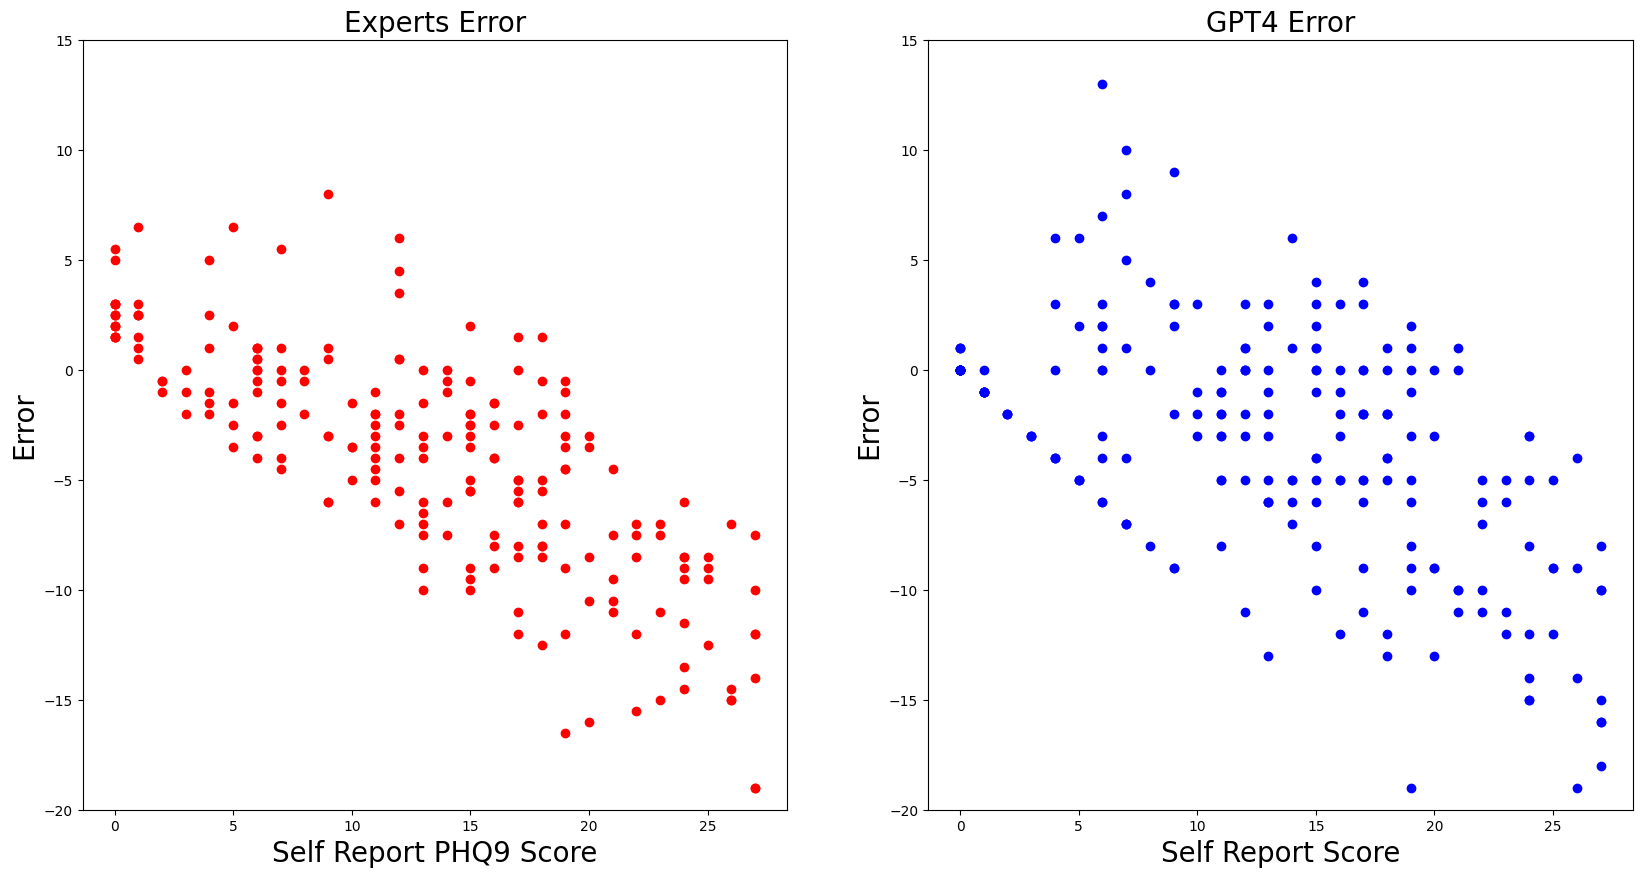

In [135]:
## Scatter Plot of experts error, gpt4 error vs target value as subplots in the same figure
## GPT4 and experts both underpredict severe cases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.scatter(gpt4_kjellScoring_merge_df.target_value.values, expert_error, color='red', label='Experts Error')
ax1.set_xlabel('Self Report PHQ9 Score', fontdict={'fontsize': 20})
ax1.set_ylabel('Error', fontdict={'fontsize': 20})
ax2.scatter(gpt4_kjellScoring_merge_df.target_value.values, gpt4_error, color='blue', label='GPT4 Error')
ax2.set_xlabel('Self Report Score', fontdict={'fontsize': 20})
ax2.set_ylabel('Error', fontdict={'fontsize': 20})
# set tile for each subplot
ax1.set_title('Experts Error', fontdict={'fontsize': 20})
ax2.set_title('GPT4 Error', fontdict={'fontsize': 20})
# set both y axis scale to be same
ax1.set_ylim([-20, 15])
ax2.set_ylim([-20, 15])
plt.show()

In [134]:
gpt4_error_df = gpt4_kjellScoring_merge_df[score_columns].sum(1) - gpt4_kjellScoring_merge_df.target_value
expert_error_df = gpt4_kjellScoring_merge_df.mean_c_a2_fmt - gpt4_kjellScoring_merge_df.target_value

In [108]:
gpt4_kjellScoring_merge_df[(gpt4_error_df.abs() > 5) & (expert_error_df.abs() < 5)][['score', 'mean_c_a2_fmt', 'target_value', 'dep_text']]

,score,mean_c_a2_fmt,target_value,dep_text
6,0.0,3.0,6,I am by nature cheerful and optimistic and hav...
16,0.0,4.5,7,I have not been depressed in the past 2 weeks....
24,0.0,7.5,8,I'm not sure about medical depression - I've b...
25,17.0,4.0,1,Depression is a state I'll never pray for my e...
33,9.0,14.5,19,I have more than anything felt worried through...
48,10.0,15.5,19,I was diagnosed with severe depression 4 years...
80,20.0,14.0,14,In the last 2 weeks i have been depressed i ha...
81,0.0,2.5,7,I do not feel that I have been depressed over ...
87,11.0,16.5,20,"Yes, I have been. I've felt tired for days on ..."


In [112]:
gpt4_kjellScoring_merge_df[(gpt4_error_df.abs() > 5) & (expert_error_df.abs() < 5)].dep_text.str.count(' ')

6     29
16    42
24    48
25    33
33    77
48    86
80    42
81    34
87    18
Name: dep_text, dtype: int64

In [109]:
gpt4_kjellScoring_merge_df[(gpt4_error_df.abs() < 5) & (expert_error_df.abs() > 5)][['score', 'mean_c_a2_fmt', 'target_value', 'dep_text']]

,score,mean_c_a2_fmt,target_value,dep_text
3,1.0,7.5,1,Over the last two weeks my mood has been posit...
42,1.0,5.5,0,For thr 2 weeks I sometimes have thr thought t...
52,9.0,18.0,12,Hopefully I've formatted everything correctly ...
55,19.0,15.5,24,I have been depressed and low these past two w...
58,22.0,19.0,26,Over the last few weeks I have experienced pro...
63,15.0,11.0,17,I know I am still feeling depressed although I...


In [113]:
gpt4_kjellScoring_merge_df[(gpt4_error_df.abs() < 5) & (expert_error_df.abs() > 5)].dep_text.str.count(' ')

3      47
42     27
52    118
55     32
58     44
63    135
Name: dep_text, dtype: int64